In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
sys.path.insert(0,"..") 
from glob import glob
from os.path import exists, join

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

import train_utils
import argparse
import skimage.transform
import sklearn.metrics
import models, models.densenet
import datasets, datasets.xray
import torchvision
import torch.nn
import pickle

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="", help='')
parser.add_argument('-name', type=str)
parser.add_argument('--output_dir', type=str, default="/lustre04/scratch/cohenjos/concept-embedding2/")
parser.add_argument('--dataset', type=str, default="nihpcchex")
parser.add_argument('--dataset_dir', type=str, default="not used yet")
parser.add_argument('--model', type=str, default="densenet121")
parser.add_argument('--seed', type=int, default=0, help='')
parser.add_argument('--cuda', type=bool, default=True, help='')
parser.add_argument('--num_epochs', type=int, default=30, help='')
parser.add_argument('--batch_size', type=int, default=64, help='')
parser.add_argument('--shuffle', type=bool, default=True, help='')
parser.add_argument('--lr', type=float, default=0.001, help='')
parser.add_argument('--threads', type=int, default=8, help='')

cfg = parser.parse_args()

In [4]:
#!mkdir $SLURM_TMPDIR/OpenI
#!rsync ~/projects/rpp-bengioy/jpcohen/OpenI/images/NLMCXR_png.tgz $SLURM_TMPDIR/OpenI
#!tar xf $SLURM_TMPDIR/OpenI/NLMCXR_png.tgz -C $SLURM_TMPDIR/OpenI/

In [5]:
#!mkdir $SLURM_TMPDIR/NIH
#!rsync ~/scratch/NIH/images-224.tar $SLURM_TMPDIR/NIH
#!tar xf $SLURM_TMPDIR/NIH/images-224.tar -C $SLURM_TMPDIR/NIH/

In [6]:
#rsync --progress /lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small.zip $SLURM_TMPDIR/

In [7]:
#os.path.join(os.getenv('SLURM_TMPDIR'), "NIH/images-224")

In [8]:
datasets.xray.default_pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [9]:
toremove = ['Lung Lesion', 'Lung Opacity', 'Enlarged Cardiomediastinum','Fracture']
toremove = []
tokeep = ~np.isin(datasets.xray.default_pathologies, toremove)

In [10]:
dataset_names = ["NIH", "PC", "CheX", "NIH_Google", "MIMIC_CH", "MIMIC_NB", "OpenI"]
datasetz = {}

In [11]:
import torchvision, torchvision.transforms
transforms = torchvision.transforms.Compose([datasets.xray.XRayCenterCrop(),datasets.xray.XRayResizer(224)])

datasetz["NIH"] = datasets.xray.NIH_XrayDataset(
        #datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "NIH/images-224"),
        datadir="/lustre04/scratch/cohenjos/NIH/images-224",
        csvpath="/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/Data_Entry_2017.csv")
    
datasetz["PC"] = datasets.xray.PC_XrayDataset(
        datadir="/lustre04/scratch/cohenjos/PC/images-224",
        csvpath="/lustre03/project/6008064/jpcohen/PADCHEST_SJ/labels_csv/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")

datasetz["CheX"] = datasets.xray.CheX_XrayDataset(
        #datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "CheXpert-v1.0-small"),
        datadir="/lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small",
        csvpath="/lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small/train.csv",
        transform=transforms)

datasetz["NIH_Google"] = datasets.xray.NIH_Google_XrayDataset(datadir="/lustre04/scratch/cohenjos/NIH/images-224",
                                      csvpath="/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/google_labels.csv")

datasetz["MIMIC_CH"] = datasets.xray.MIMIC_XrayDataset(
          datadir="/lustre04/scratch/cohenjos/MIMIC/images-224/files",
          csvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-chexpert.csv.gz",
          metacsvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-metadata.csv.gz")

datasetz["MIMIC_NB"] = datasets.xray.MIMIC_XrayDataset(
          datadir="/lustre04/scratch/cohenjos/MIMIC/images-224/files",
          csvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-negbio.csv.gz",
          metacsvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-metadata.csv.gz")

datasetz["OpenI"] = datasets.xray.Openi_XrayDataset(#datadir="/lustre03/project/6008064/jpcohen/OpenI/NLMCXR_png/images/",
            datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "OpenI"),
            xmlpath="/lustre03/project/6008064/jpcohen/OpenI/ecgen-radiology/",
            transform=transforms)


In [12]:
#pathologies = ['Consolidation', 'Infiltration','Pneumonia']#, 'Effusion']
pathologies = datasets.xray.default_pathologies

In [13]:
#datasetz["MIMIC_NB"].pathologies

In [14]:
for dataset_name in dataset_names:
    print(dataset_name)
    datasets.xray.relabel_dataset(pathologies, datasetz[dataset_name])

NIH
Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
PC
Lung Lesion doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
CheX
{'Support Devices', 'Pleural Other'} will be dropped
Infiltration doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Pleural_Thickening doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.
NIH_Google
{'Nodule or mass'} will be dropped
Atelectasis doesn't exist. Adding nans instead.
Consolidation doesn't exist. Adding nans instead.
Infiltration doesn't exist. Adding nans instead.
Edema doesn't exist. Adding nans instead.
Emphysema doe

In [15]:
# for dataset_name in dataset_names:
#     print(dataset_name)
#     # apply filter for 1 path only
#     datasetz[dataset_name] = datasets.xray.FilterDataset(datasetz[dataset_name])

In [16]:
datasetz["NIH"]

{'Atelectasis': [(0.0, 29103), (1.0, 1702)],
 'Cardiomegaly': [(0.0, 30038), (1.0, 767)],
 'Consolidation': [(0.0, 30378), (1.0, 427)],
 'Edema': [(0.0, 30723), (1.0, 82)],
 'Effusion': [(0.0, 29525), (1.0, 1280)],
 'Emphysema': [(0.0, 30540), (1.0, 265)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 30234), (1.0, 571)],
 'Fracture': [],
 'Hernia': [(0.0, 30722), (1.0, 83)],
 'Infiltration': [(0.0, 27201), (1.0, 3604)],
 'Lung Lesion': [],
 'Lung Opacity': [],
 'Mass': [(0.0, 29525), (1.0, 1280)],
 'Nodule': [(0.0, 29144), (1.0, 1661)],
 'Pleural_Thickening': [(0.0, 30042), (1.0, 763)],
 'Pneumonia': [(0.0, 30637), (1.0, 168)],
 'Pneumothorax': [(0.0, 30536), (1.0, 269)]}


NIH_XrayDataset num_samples=30805

In [17]:
datasetz["PC"]

{'Atelectasis': [(0.0, 59674), (1.0, 2441)],
 'Cardiomegaly': [(0.0, 56725), (1.0, 5390)],
 'Consolidation': [(0.0, 61621), (1.0, 494)],
 'Edema': [(0.0, 62007), (1.0, 108)],
 'Effusion': [(0.0, 60478), (1.0, 1637)],
 'Emphysema': [(0.0, 61569), (1.0, 546)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 61774), (1.0, 341)],
 'Fracture': [(0.0, 60450), (1.0, 1665)],
 'Hernia': [(0.0, 61127), (1.0, 988)],
 'Infiltration': [(0.0, 57677), (1.0, 4438)],
 'Lung Lesion': [],
 'Lung Opacity': [],
 'Mass': [(0.0, 61608), (1.0, 507)],
 'Nodule': [(0.0, 59921), (1.0, 2194)],
 'Pleural_Thickening': [(0.0, 60039), (1.0, 2076)],
 'Pneumonia': [(0.0, 60064), (1.0, 2051)],
 'Pneumothorax': [(0.0, 62017), (1.0, 98)]}


PC_XrayDataset num_samples=62115

In [18]:
datasetz["CheX"]

{'Atelectasis': [(0.0, 14317), (1.0, 12691)],
 'Cardiomegaly': [(0.0, 17765), (1.0, 9099)],
 'Consolidation': [(0.0, 22504), (1.0, 5390)],
 'Edema': [(0.0, 20615), (1.0, 14929)],
 'Effusion': [(0.0, 23500), (1.0, 20640)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 20506), (1.0, 5181)],
 'Fibrosis': [],
 'Fracture': [(0.0, 14948), (1.0, 4250)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 14422), (1.0, 4217)],
 'Lung Opacity': [(1.0, 30873), (0.0, 15675)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 14793), (1.0, 2822)],
 'Pneumothorax': [(0.0, 32685), (1.0, 4311)]}


CheX_XrayDataset num_samples=64534

In [19]:
datasetz["NIH_Google"]

{'Atelectasis': [],
 'Cardiomegaly': [],
 'Consolidation': [],
 'Edema': [],
 'Effusion': [],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [],
 'Fracture': [(0.0, 1635), (1.0, 60)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [],
 'Lung Opacity': [(0.0, 1094), (1.0, 601)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [],
 'Pneumothorax': [(0.0, 1623), (1.0, 72)]}


NIH_Google_XrayDataset num_samples=1695

In [20]:
datasetz["MIMIC_CH"]

{'Atelectasis': [(0.0, 30954), (1.0, 4077)],
 'Cardiomegaly': [(0.0, 32312), (1.0, 3743)],
 'Consolidation': [(0.0, 32297), (1.0, 816)],
 'Edema': [(0.0, 33610), (1.0, 1157)],
 'Effusion': [(0.0, 33401), (1.0, 3713)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 31505), (1.0, 692)],
 'Fibrosis': [],
 'Fracture': [(0.0, 30961), (1.0, 972)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 31033), (1.0, 1321)],
 'Lung Opacity': [(0.0, 31175), (1.0, 5426)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 33347), (1.0, 2176)],
 'Pneumothorax': [(0.0, 33651), (1.0, 560)]}


MIMIC_XrayDataset num_samples=45628

In [21]:
datasetz["MIMIC_NB"]

{'Atelectasis': [(0.0, 32058), (1.0, 4048)],
 'Cardiomegaly': [(0.0, 33431), (1.0, 3275)],
 'Consolidation': [(0.0, 33564), (1.0, 762)],
 'Edema': [(0.0, 34731), (1.0, 1121)],
 'Effusion': [(0.0, 34489), (1.0, 3595)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 32641), (1.0, 660)],
 'Fibrosis': [],
 'Fracture': [(0.0, 32320), (1.0, 696)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 32187), (1.0, 1271)],
 'Lung Opacity': [(0.0, 32371), (1.0, 5301)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 34479), (1.0, 2042)],
 'Pneumothorax': [(0.0, 34760), (1.0, 500)]}


MIMIC_XrayDataset num_samples=45628

In [22]:
datasetz["OpenI"]

{'Atelectasis': [(0.0, 2996), (1.0, 271)],
 'Cardiomegaly': [(0.0, 3082), (1.0, 185)],
 'Consolidation': [],
 'Edema': [(0.0, 3217), (1.0, 50)],
 'Effusion': [(0.0, 3147), (1.0, 120)],
 'Emphysema': [(0.0, 3183), (1.0, 84)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 3250), (1.0, 17)],
 'Fracture': [(0.0, 3189), (1.0, 78)],
 'Hernia': [(0.0, 3226), (1.0, 41)],
 'Infiltration': [(0.0, 3201), (1.0, 66)],
 'Lung Lesion': [(0.0, 3264), (1.0, 3)],
 'Lung Opacity': [(0.0, 2940), (1.0, 327)],
 'Mass': [(0.0, 3261), (1.0, 6)],
 'Nodule': [(0.0, 3199), (1.0, 68)],
 'Pleural_Thickening': [(0.0, 3237), (1.0, 30)],
 'Pneumonia': [(0.0, 3199), (1.0, 68)],
 'Pneumothorax': [(0.0, 3253), (1.0, 14)]}


Openi_XrayDataset num_samples=3267

In [23]:
train_datasets = {}
test_datasets = {}
test_loaders = {}
for dataset_name in dataset_names:
    train_size = int(0.5 * len(datasetz[dataset_name]))
    test_size = len(datasetz[dataset_name]) - train_size
    torch.manual_seed(0)
    train_datasets[dataset_name], test_datasets[dataset_name] = torch.utils.data.random_split(datasetz[dataset_name], [train_size, test_size])
    
    #fix labels
    train_datasets[dataset_name].labels = datasetz[dataset_name].labels[train_datasets[dataset_name].indices]
    test_datasets[dataset_name].labels = datasetz[dataset_name].labels[test_datasets[dataset_name].indices]
    
    test_loaders[dataset_name] = torch.utils.data.DataLoader(test_datasets[dataset_name],
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=32, pin_memory=cfg.cuda)
    

In [24]:
# model = models.densenet.DenseNet(num_classes=len(datasets.xray.default_pathologies), in_channels=1, 
#                                  **models.densenet.get_densenet_params("densenet121"))

In [25]:
def plot_aucs(model_names, title):
    plt.figure(0, figsize=(35, 2), dpi=300)
    lines = []
    colors = ["red", "blue", "orange"]
    #for i in range(5):
    num_path = len(datasets.xray.default_pathologies)-3
    i = -1
    for x in range(num_path):
        i += 1
        res = results[list(results)[0]] # just to filter. This should be done better
        all_labels = res[3]
        if datasets.xray.default_pathologies[i] in toremove:
            i -= 1
            continue
        elif (all_labels[i] == 0).all():
            print("|", datasets.xray.default_pathologies[i], "|", "ERR |")
            ax = plt.subplot2grid((1,num_path),(0,i))
            ax.axis('off')
        else:
#             xplot = i // (num_path//2)
#             yplot = i % (num_path//2)
#             ax = plt.subplot2grid((2, (num_path//2)), (xplot, yplot))
            ax = plt.subplot2grid((1,num_path),(0,i))
            legend = []
            for j, model_name in enumerate(model_names):

                res = results[model_name]
                all_labels = res[3]
                all_outputs = res[2]
                # Save ROC curve
                fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels[i], all_outputs[i])

                auc = sklearn.metrics.roc_auc_score(all_labels[i], all_outputs[i])
                

                # if the model was trained on this label
                if model_name == "Merge" or np.nansum(datasetz[model_name].labels[:,i]) > 0:
                    line = ax.plot(fpr, tpr, label=model_name)#, color=colors[j])
                    legend.append(model_name + "=" + str(auc)[:4])
                else:
                    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))
                    legend.append(model_name + "=N/A")
                if i == 0:
                    lines.append(line[0])

            ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), c="black")
            ax.set_title(datasets.xray.default_pathologies[i] + "\n(N={})".format(int(np.nansum(all_labels[i]))))
            ax.tick_params(top=False, bottom=False, left=False, right=False)
            ax.set_yticks([0, 0.5, 1])
            if i > 0:
                ax.set_yticks([])

            plt.subplots_adjust(hspace = 0.5)
            plt.legend(handles=lines,
                       labels=legend,
                       title="Model",
                       prop={'size': 9},
                       #bbox_to_anchor=(1.1, 1.05)
                       )
    #plt.subplots_adjust(top=0.5)
    plt.subplots_adjust(wspace=0.1)
    plt.suptitle(title, y=1.2)
    plt.show();
    plt.tight_layout();


In [26]:
#plot_aucs(model_names, "Testset:" + testset_name)

In [27]:
datasets.xray.default_pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [31]:
!ls /home/cohenjos/scratch/concept-embedding2/*best* | grep -v XrayDataset

/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt
/home/cohenjos/scratch/concept-embedding2/nih-den

In [28]:
model_names = ["NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB", "nihpcchexmimic_chmimic_nbgoogle"]
#model_names = ["NIH"]#, "PC", "CheX"]

In [29]:
testset_names = ["NIH", "PC", "CheX", "NIH_Google", "MIMIC_CH", "MIMIC_NB", "OpenI"]
#testset_names = ["NIH_Google"]

In [30]:
testset_names

['NIH', 'PC', 'CheX', 'NIH_Google', 'MIMIC_CH', 'MIMIC_NB', 'OpenI']

In [31]:
#!rm results-da-new*

In [32]:
#os.path.exists("results-da-new-seeds-NIH.pkl")

In [ ]:
for testset_name in testset_names:
    for model_name in model_names:
        print(testset_name, model_name)
        path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
        if os.path.exists(path):
            print("skipping", testset_name, model_name)
            continue
        results_model = {}
        for seed in range(3):
            model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_name.lower(), seed))
            results_model[seed] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)

        pickle.dump(results_model, open(path, "bw"))
    

In [ ]:
# for model_name in ["MIMIC_CH", "MIMIC_NB", "nihpcchexmimic_chmimic_nbgoogle"]:
#     if model_name == "Merge":
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt")
#     else:
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt".format(model_name.lower()))
#     results[model_name] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


| Infiltration | ERR |
| Emphysema | ERR |
| Fibrosis | ERR |
| Pleural_Thickening | ERR |
| Nodule | ERR |
| Mass | ERR |
| Hernia | ERR |


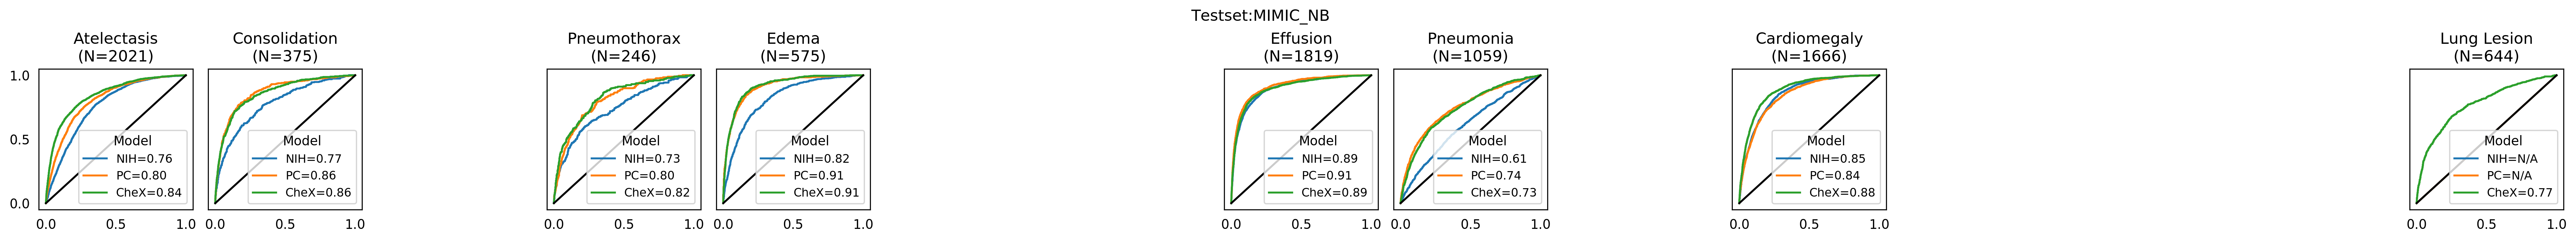

<Figure size 432x288 with 0 Axes>

In [69]:
plot_aucs(model_names, "Testset:" + testset_name)

In [27]:
# pickle.dump(results, open("results-da-new-{}.pkl".format(testset_name), "bw"))


In [ ]:
# testset_name = "NIH"
# results = pickle.load(open("results-da-new-seeds-{}.pkl".format(testset_name), "br"))

In [33]:
def get_avg_auc(results):
    resultsnew = {}
    for model_name in results.keys():
        resultsnew[model_name] = {}
        resultsnew[model_name][0] = {} # single seed now
        resultsnew[model_name][0][2] = {}
        resultsnew[model_name][0][3] = {}
        task_aucs = []
        for task in range(len(results[model_name][0][2])):
            avg = [results[model_name][seed][2][task] for seed in range(3)] # 3 seeds
            gt = results[model_name][0][3][task]
            avg = np.asarray(avg).mean(0)
            resultsnew[model_name][0][2][task] = avg
            resultsnew[model_name][0][3][task] = gt
            if len(np.unique(gt))> 1:
                task_auc = sklearn.metrics.roc_auc_score(gt, avg)
                task_aucs.append(task_auc)
            else:
                task_aucs.append(np.nan)
        resultsnew[model_name][0][1] = np.array(task_aucs)
    return resultsnew

| Infiltration | ERR |
| Emphysema | ERR |
| Fibrosis | ERR |
| Pleural_Thickening | ERR |
| Nodule | ERR |
| Mass | ERR |
| Hernia | ERR |


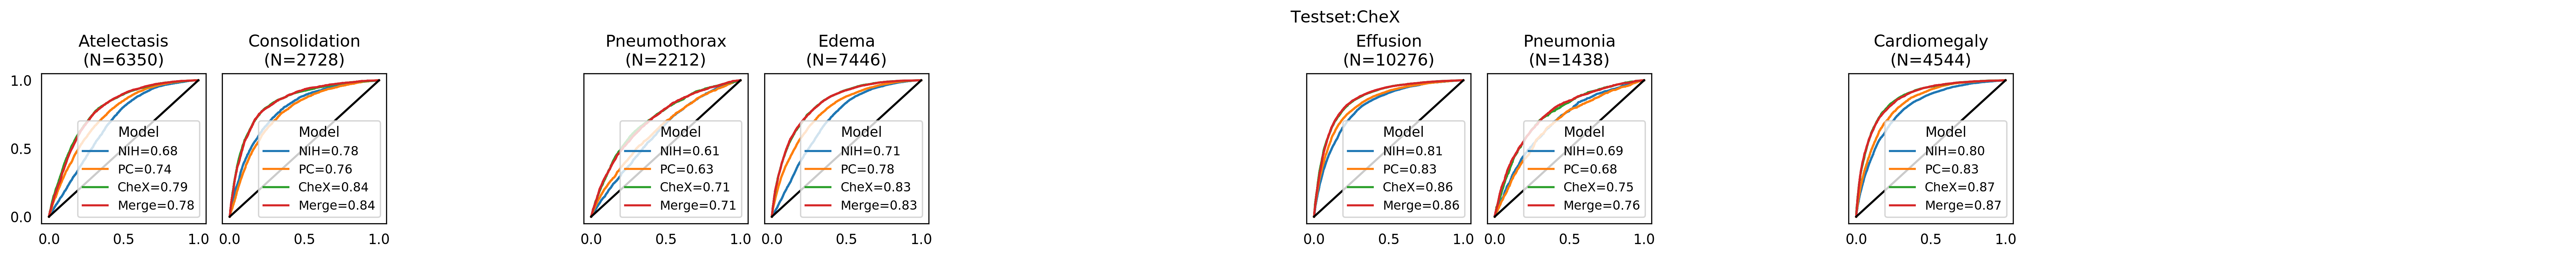

<Figure size 432x288 with 0 Axes>

In [229]:
plot_aucs(model_names, "Testset:" + testset_name)

In [34]:
pathologies = datasets.xray.default_pathologies
neworder = ['Pneumothorax',
            'Effusion',
            'Atelectasis',
             'Edema',
             'Fracture',
             'Lung Opacity',
             'Lung Lesion',
             'Cardiomegaly',
             'Enlarged Cardiomediastinum',
             'Emphysema',
             'Fibrosis',
             'Pleural_Thickening',
             'Nodule',
             'Mass',
             'Hernia',
            'Pneumonia',
            'Consolidation',
            'Infiltration',]
neworder_idx = [pathologies.index(path) for path in neworder]

In [35]:
model_names = ["nihpcchexmimic_chmimic_nbgoogle", "NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB"]

In [36]:
dataset_names = ['NIH', 'PC', 'NIH_Google', 'CheX', 'MIMIC_CH', 'MIMIC_NB', 'OpenI']

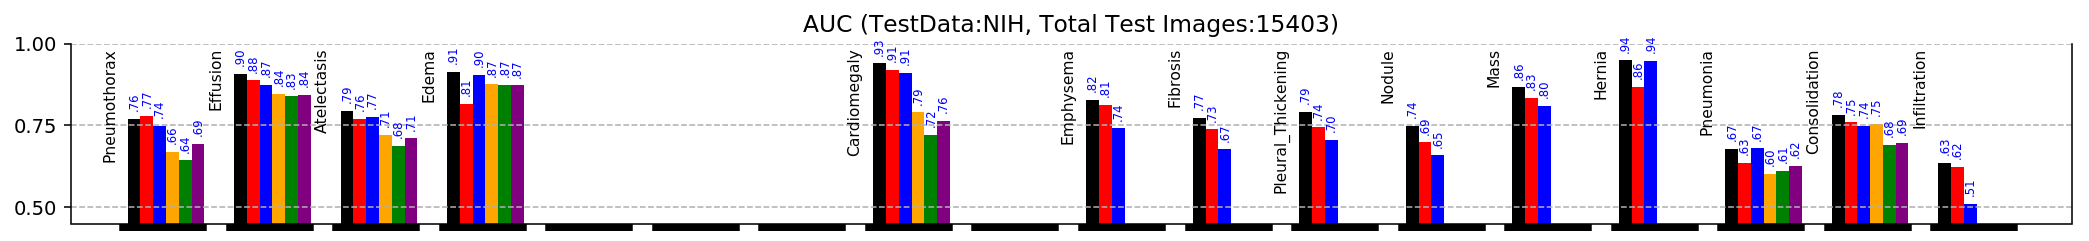

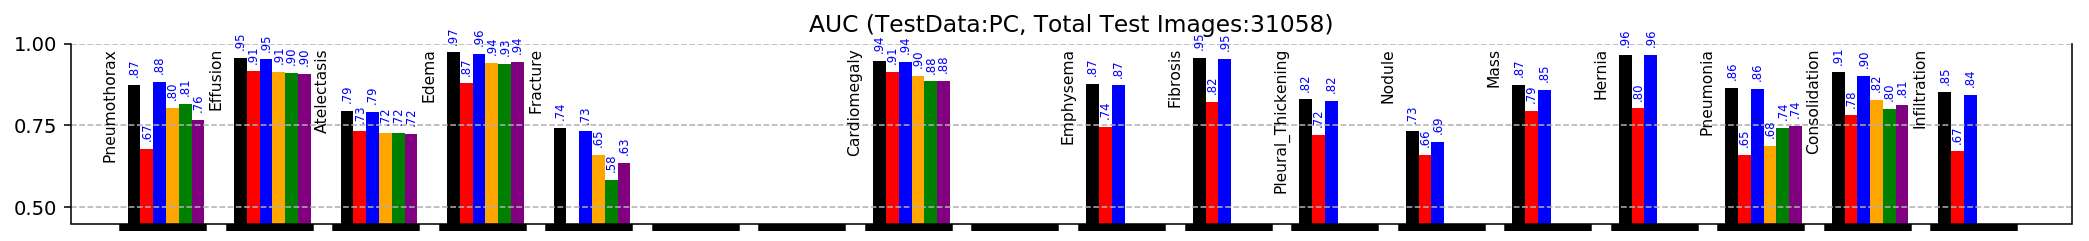

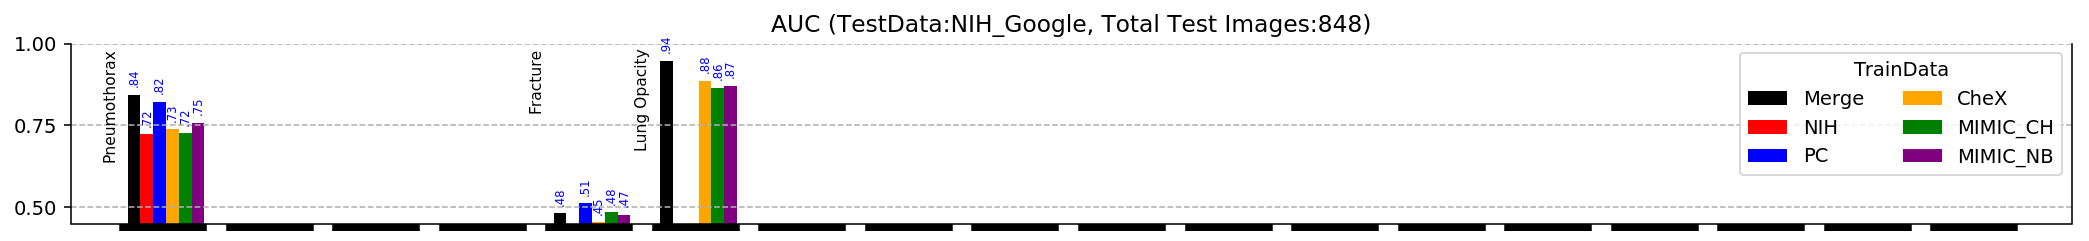

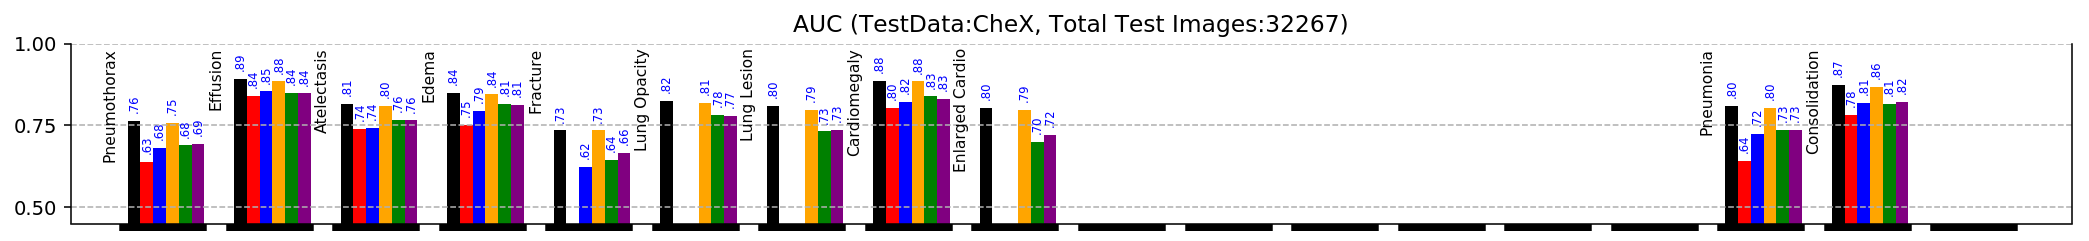

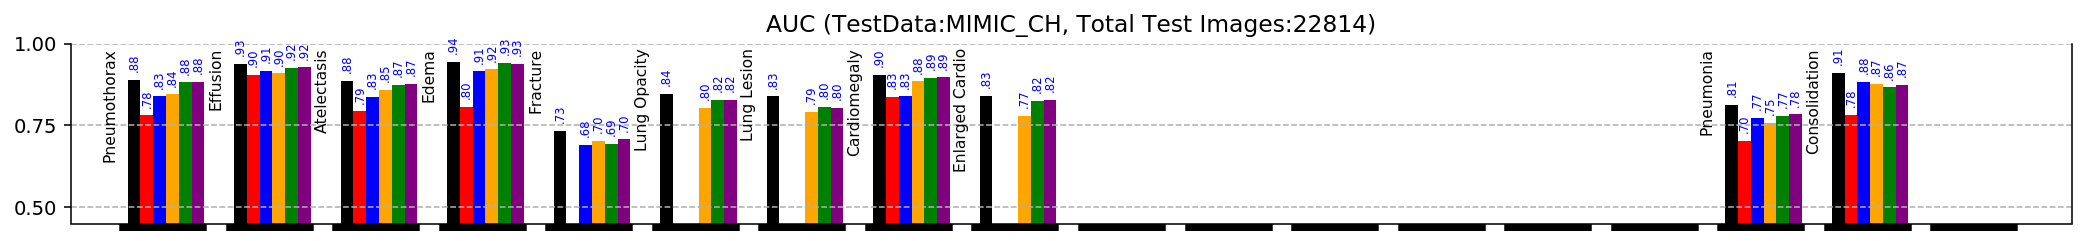

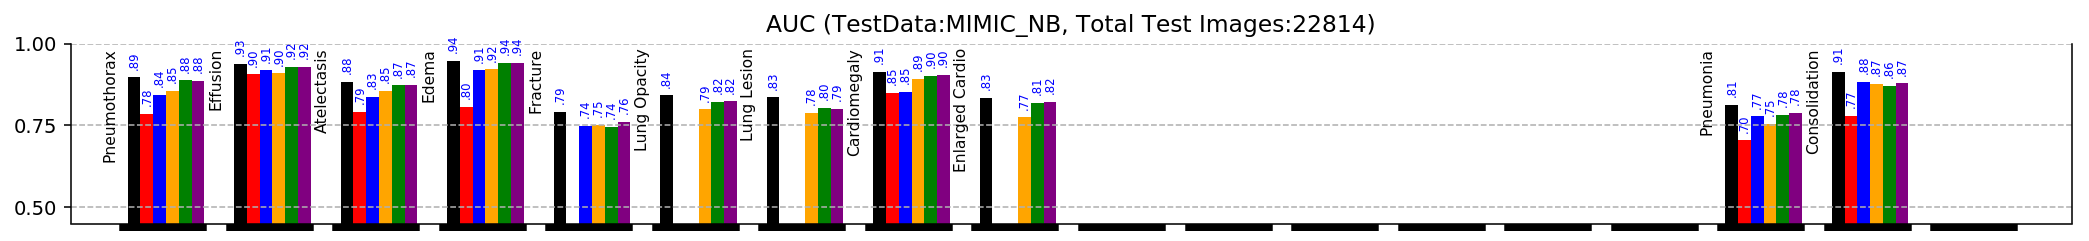

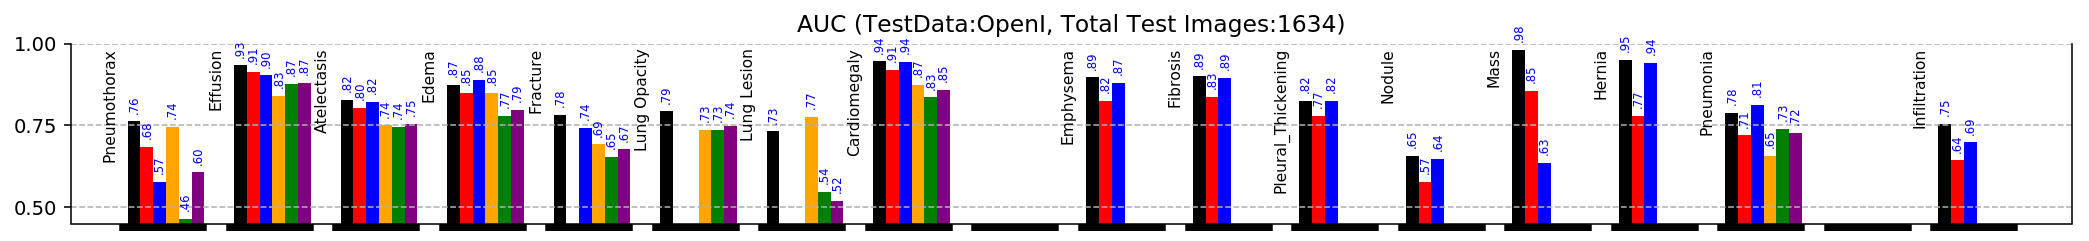

In [38]:
colors = ["black", "red", "blue", "orange", "green", "purple"]
for ii, testset_name in enumerate(dataset_names):
    results = {}
    for model_name in model_names:
        results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

    # to avg over seeds
    results = get_avg_auc(results)
    
    plt.figure(0, figsize=(15, 1.8), dpi=140)
    index = np.arange(len(results["NIH"][0][1][tokeep]))  # the label locations
    width = 0.12  # the width of the bars

    plt.yticks([0,0.25, 0.5,0.75,1])
    plt.grid(which='major', axis='y', linestyle='--')

    pathos = []
    countTotal = test_datasets[testset_name].labels.shape[0]
    counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
    countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
    for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
        #pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ",T=" + str(int(countsT[i])) + ")")
        pathos.append(patho.replace("Cardiomediastinum", "Cardio"))# + "\n (" + str(int(countsT[i]))+ "/" + str(int(counts[i])) + ")")

    
    for offset, model_name in enumerate(model_names):
        toplot = results[model_name][0][1][tokeep]
        toplot[np.isnan(toplot)] = 0
        if model_name == "nihpcchexmimic_chmimic_nbgoogle":
            model_name = "Merge"
        if model_name != "Merge":
            valid = (np.nansum(datasetz[model_name].labels, axis=0) > 0)
            toplot[~valid[tokeep]] = 0
        
        plt.bar(index+offset*width, toplot[neworder_idx], width, label=model_name, color=colors[offset]);
        for i, v in enumerate(toplot[neworder_idx]):
            if v > 0.4:
                plt.text(i+offset*width-width/2,v+0.05, str(v)[1:4], color='blue', fontsize=6, rotation='90')
                
        if offset == 0:
            for i, v in enumerate(toplot[neworder_idx]):
                if v > 0.4:
                    plt.text(i+(offset-2.0)*width-width/2,0.95, np.asarray(pathos)[neworder_idx][i], color='black', fontsize=8, rotation='90', ha='left')

    plt.margins(x=0.03)
    plt.xticks(index + 2.3*width, 
               [""]*18,
               rotation='30',horizontalalignment="right", fontsize=10)
    ax = plt.gca()
    ax.xaxis.set_tick_params(width=45)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='major', pad=0)
    if ii == 2:
        plt.legend(title="TrainData", ncol=2)#,bbox_to_anchor=(-0.05, 1.1));
    plt.ylim(0.45,1)
    plt.title("AUC (TestData:{}, Total Test Images:{})".format(testset_name, countTotal));
    #plt.subplots_adjust(left=10)
    plt.subplots_adjust(left=0.1)
    plt.tight_layout(pad=1)
    plt.savefig("auc-bar-{}.png".format(testset_name.lower()))
    plt.show()


In [106]:
# #plt.figure(0, figsize=(15, 1.6), dpi=150)
# f, axs = plt.subplots(7, 1, figsize=(17, 15), dpi=150)

# for ii, testset_name in enumerate(dataset_names):
#     if ii > 1:
#         break
#     results = {}
#     for model_name in model_names:
#         results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

#     # to avg over seeds
#     results = get_avg_auc(results)
    
    
#     index = np.arange(len(results["NIH"][0][1][tokeep]))  # the label locations
#     width = 0.12  # the width of the bars

# #     plt.yticks([0,0.25, 0.5,0.75,1])
# #     plt.grid(which='major', axis='y', linestyle='--')

#     for offset, model_name in enumerate(model_names):
#         toplot = results[model_name][0][1][tokeep]
#         toplot[np.isnan(toplot)] = 0
#         if model_name == "nihpcchexmimic_chmimic_nbgoogle":
#             model_name = "Merge"
#         if model_name != "Merge":
#             valid = (np.nansum(datasetz[model_name].labels, axis=0) > 0)
#             toplot[~valid[tokeep]] = 0
        
#         axs[ii].bar(index+offset*width, toplot, width, label=model_name);
#         for i, v in enumerate(toplot):
#             if v > 0.4:
#                 axs[ii].text(i+offset*width-width/2,v+0.05, str(v)[1:4], color='blue', fontsize=6, rotation='90')
#     pathos = []
#     countTotal = test_datasets[testset_name].labels.shape[0]
#     counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
#     countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
#     for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
#         #pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ",T=" + str(int(countsT[i])) + ")")
#         pathos.append(patho.replace("Cardiomediastinum", "Cardio") + "\n (" + str(int(countsT[i]))+ "/" + str(int(counts[i])) + ")")

# #     plt.margins(x=0.01)
#     #axs[ii].set_xticklabels(index + 2.5*width,pathos)
#     plt.setp(axs[ii].get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=10)
# #     ax = plt.gca()
#     #axs[ii].xaxis.set_tick_params(width=40)
#     #axs[ii].tick_params(axis='x', which='major', pad=0)
#     if ii == 0:
#         axs[ii].legend(title="TrainData", ncol=2)#,bbox_to_anchor=(-0.05, 1.1));
#     axs[ii].set_ylim(0.45,1)
#     axs[ii].set_title("AUC (TestData:{}, Total Images:{})".format(testset_name, countTotal));
#     plt.subplots_adjust(hspace=1)
# #     plt.subplots_adjust(left=0.1)
# #     #plt.tight_layout(pad=1)
# #     plt.show()


In [88]:
pathos[:2]

['Atelectasis\n (866/15403)', 'Consolidation\n (203/15403)']

In [101]:
# for i, testset_name in enumerate(dataset_names):
#     results = pickle.load(open("results-{}.pkl".format(testset_name), "br"))

#     plt.figure(0, figsize=(10, 1.3), dpi=150)
#     index = np.arange(len(results["NIH"][1][tokeep]))  # the label locations
#     width = 0.15  # the width of the bars

#     plt.yticks([0,0.25, 0.5,0.75,1])
#     plt.grid(which='major', axis='y', linestyle='--')

#     for offset, model_name in enumerate(model_names):
#         toplot = results[model_name][1][tokeep]
#         toplot[np.isnan(toplot)] = 0
#         if model_name != "Merge":
#             valid = (np.nansum(datasetz[model_name].labels, axis=0) > 0)
#             toplot[~valid[tokeep]] = 0
        
#         plt.bar(index+offset*width, toplot, width, label=model_name);
#     pathos = []
#     counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
#     countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
#     for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
#         pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ", T=" + str(int(countsT[i])) + ")")

#     plt.xticks(index + 1.3*width, 
#                pathos,
#                rotation='40',horizontalalignment="right", fontsize=7)
#     plt.legend(title="TrainData",bbox_to_anchor=(-0.05, 1.1));
#     plt.ylim(0.4,1)
#     plt.title("AUC (TestData:{})".format(testset_name));
#     plt.show()


In [102]:
# for i, testset_name in enumerate(dataset_names):
#     results = pickle.load(open("results-{}.pkl".format(testset_name), "br"))

#     plt.figure(0, figsize=(1.3, 5), dpi=150)
#     index = np.arange(len(results["NIH"][1][tokeep]))  # the label locations
#     width = 0.2  # the width of the bars

#     plt.xticks([0,0.25, 0.5,0.75,1])
#     plt.grid(which='major', axis='x', linestyle='--')

#     for offset, model_name in enumerate(model_names):
#         toplot = results[model_name][1][tokeep]
#         toplot[np.isnan(toplot)] = 0
#         if model_name != "Merge":
#             valid = (np.nansum(datasetz[model_name].labels, axis=0) > 0)
#             toplot[~valid[tokeep]] = 0
        
#         plt.barh(index+offset*width, toplot, width, label=model_name);
#     pathos = []
#     counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
#     countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
#     for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
#         #pathos.append(patho + "\n N=" + str(int(counts[i]))+ "\n T=" + str(int(countsT[i])) + "")
#         pathos.append(patho + "\n " + str(int(countsT[i])) + "/" + str(int(counts[i])))

#     plt.yticks(index + 1*width, 
#                pathos,
#                rotation='0',horizontalalignment="right", fontsize=7)
#     if testset_name == "CheX":
#         plt.legend(title="TrainData",bbox_to_anchor=(2, 1), fontsize=7);
#     plt.xlim(0.5,1)
#     plt.tight_layout()
#     plt.title("AUC (TestData:{})".format(testset_name));
#     plt.show()


In [92]:
# model = torch.load("/home/cohenjos/scratch/concept-embedding2/NIH_XrayDataset-densenet121-d121-tw-lr001-best.pt")
# results["NIH1"] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


In [93]:
# model = torch.load("/home/cohenjos/scratch/concept-embedding2/NIH_XrayDataset-densenet121-d121-tw-lr01-best.pt")
# results["NIH2"] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


In [39]:
def op_thres(all_labels, all_outputs):
    fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels, all_outputs)
    pente = tpr - fpr
    opt_thres = thres[np.argmax(pente)]
    return np.asarray(all_outputs > opt_thres).astype(int)

In [40]:
def op_norm(all_labels, all_outputs, sigmoid=True):
    
    if sigmoid:
        all_outputs = 1.0/(1.0 + np.exp(-all_outputs))
        
    fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels, all_outputs)
    pente = tpr - fpr
    opt_thres = thres[np.argmax(pente)]
    
    normed = []
    for i in range(len(all_outputs)):
        if (all_outputs[i]<opt_thres):
            value_normalized = all_outputs[i]/(opt_thres*2) 
        else:
            value_normalized = 1-((1-all_outputs[i])/((1-(opt_thres))*2)) 
        normed.append(value_normalized)
    
    return np.asarray(normed)

In [41]:
# testset_name = "CheX"
# results = pickle.load(open("results-{}.pkl".format(testset_name), "br"))

In [42]:
def kappa(aa, bb):
    # the relative observed agreement among raters.
    p_o = (aa==bb).mean()
    # the hypothetical probability of chance agreement
    random_yes = (aa == 1).mean() * (bb == 1).mean()
    random_no = (aa == 0).mean() * (bb == 0).mean()
    p_e = random_yes + random_no
    k = (p_o-p_e)/(1-p_e)
    return k


    #print(datasets.xray.default_pathologies[i] + "=" + str(k)[:5])

In [43]:
model_names

['nihpcchexmimic_chmimic_nbgoogle',
 'NIH',
 'PC',
 'CheX',
 'MIMIC_CH',
 'MIMIC_NB']

In [44]:
dataset_names

['NIH', 'PC', 'NIH_Google', 'CheX', 'MIMIC_CH', 'MIMIC_NB', 'OpenI']

In [46]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']

In [50]:
dataset_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']

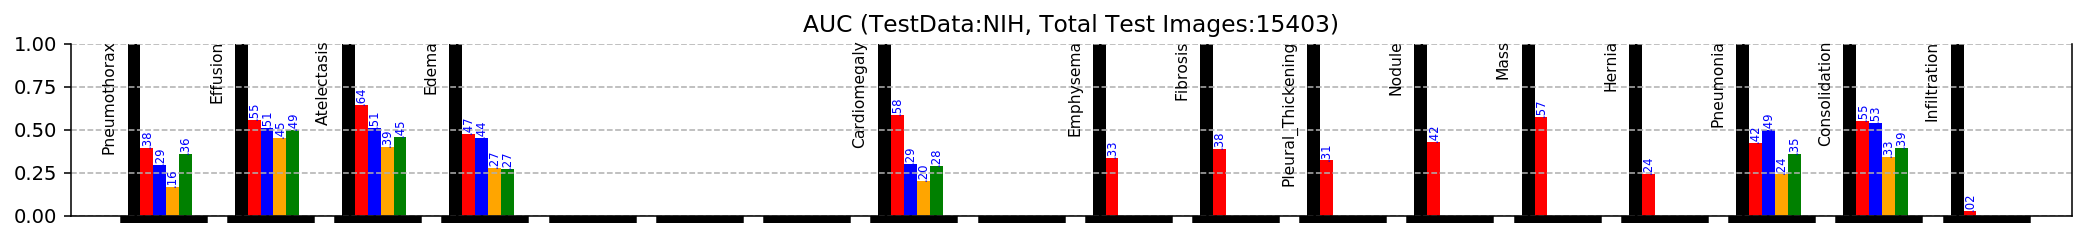

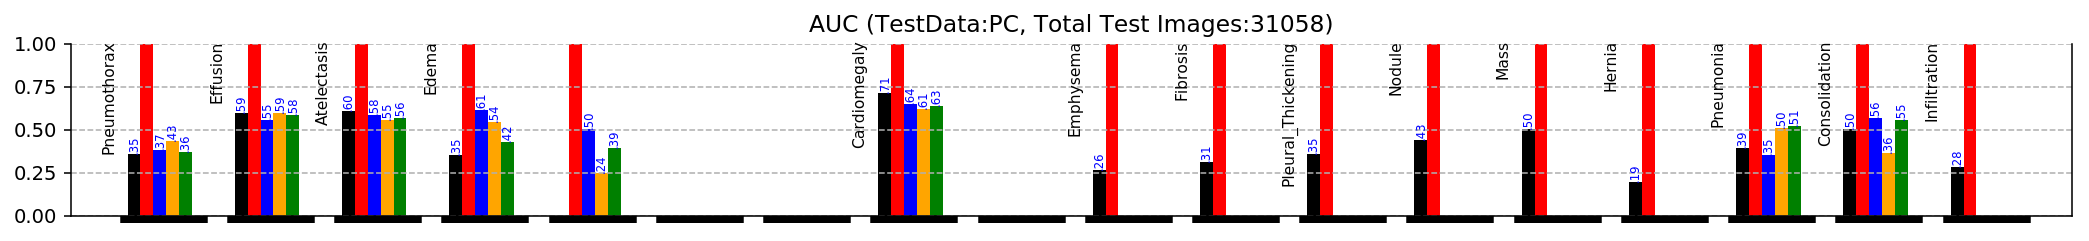

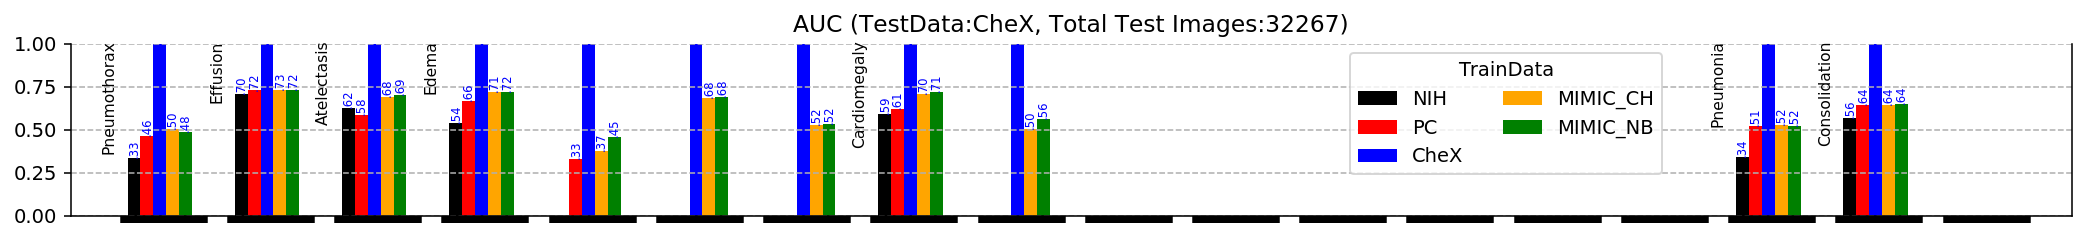

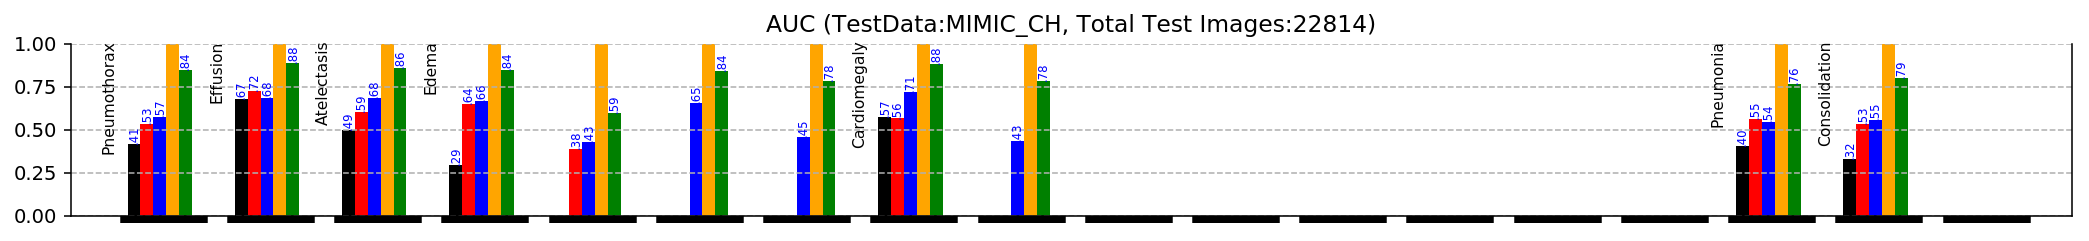

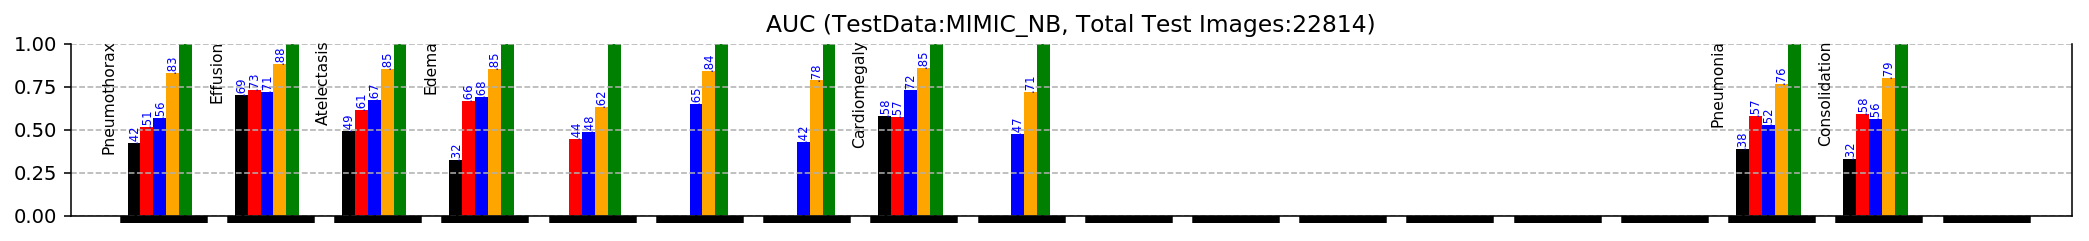

In [62]:
colors = ["black", "red", "blue", "orange", "green", "purple"]
for ii, testset_name in enumerate(dataset_names):
    results = {}
    for model_name in model_names:
        results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

    # to avg over seeds
    results = get_avg_auc(results)
    
    all_kappas = {}
    for model_name in model_names:
        kappas = []
        for i in range(len(datasets.xray.default_pathologies)):
            if len(results[testset_name][0][3][i]) > 0:
                aa = op_thres(results[testset_name][0][3][i], results[testset_name][0][2][i])
                bb = op_thres(results[model_name][0][3][i], results[model_name][0][2][i])
                
                #k = 1-np.abs(aa-bb).mean()
                k = kappa(aa, bb)
                kappas.append(k)
            else:
                kappas.append(-5)
        all_kappas[model_name] = np.asarray(kappas)
    
    plt.figure(0, figsize=(15, 1.8), dpi=140)
    index = np.arange(len(results["NIH"][0][1][tokeep]))  # the label locations
    width = 0.12  # the width of the bars

    plt.yticks([0,0.25, 0.5,0.75,1])
    plt.grid(which='major', axis='y', linestyle='--')

    pathos = []
    countTotal = test_datasets[testset_name].labels.shape[0]
    counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
    countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
    for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
        #pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ",T=" + str(int(countsT[i])) + ")")
        pathos.append(patho.replace("Cardiomediastinum", "Cardio"))# + "\n (" + str(int(countsT[i]))+ "/" + str(int(counts[i])) + ")")

    
    for offset, model_name in enumerate(model_names):
        all_kappas[model_name][all_kappas[model_name]==-5] = 0
        if model_name != "nihpcchexmimic_chmimic_nbgoogle":
            not_exists_for_model = np.nansum(datasetz[model_name].labels, axis=0) == 0
            all_kappas[model_name][not_exists_for_model] = 0
        toplot = all_kappas[model_name][tokeep]
        if model_name == "nihpcchexmimic_chmimic_nbgoogle":
            model_name = "Merge"
#         toplot = results[model_name][0][1][tokeep]
#         toplot[np.isnan(toplot)] = 0
#         if model_name == "nihpcchexmimic_chmimic_nbgoogle":
#             model_name = "Merge"
#         if model_name != "Merge":
#             valid = (np.nansum(datasetz[model_name].labels, axis=0) > 0)
#             toplot[~valid[tokeep]] = 0
        
        plt.bar(index+offset*width, toplot[neworder_idx], width, label=model_name, color=colors[offset]);
        for i, v in enumerate(toplot[neworder_idx]):
            if (v > 0) and (v != 1):
                plt.text(i+offset*width-width/2,v+0.05, str(v)[1:4], color='blue', fontsize=6, rotation='90')
                
        if offset == 0:
            for i, v in enumerate(toplot[neworder_idx]):
                if v > 0:
                    plt.text(i+(offset-2.0)*width-width/2,0.95, np.asarray(pathos)[neworder_idx][i], color='black', fontsize=8, rotation='90', ha='left')

    plt.margins(x=0.03)
    plt.xticks(index + 2.3*width, 
               [""]*18,
               rotation='30',horizontalalignment="right", fontsize=10)
    ax = plt.gca()
    ax.xaxis.set_tick_params(width=45)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='major', pad=0)
    if ii == 2:
        plt.legend(title="TrainData", ncol=2, bbox_to_anchor=(0.8, 1));
    plt.ylim(0,1)
    plt.title("AUC (TestData:{}, Total Test Images:{})".format(testset_name, countTotal));
    #plt.subplots_adjust(left=10)
    plt.subplots_adjust(left=0.1)
    plt.tight_layout(pad=1)
    plt.savefig("kappa-{}.png".format(testset_name.lower()))
    plt.show()


In [63]:
# for ii, testset_name in enumerate(['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']):#dataset_names):
#     results = {}
#     for model_name in model_names:
#         results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

#     # to avg over seeds
#     results = get_avg_auc(results)

#     all_kappas = {}
#     for model_name in model_names:
#         kappas = []
#         for i in range(len(datasets.xray.default_pathologies)):
#             if len(results[testset_name][0][3][i]) > 0:
#                 aa = op_thres(results[testset_name][0][3][i], results[testset_name][0][2][i])
#                 bb = op_thres(results[model_name][0][3][i], results[model_name][0][2][i])
                
#                 k = 1-np.abs(aa-bb).mean()
#                 #k = kappa(aa, bb)
#                 kappas.append(k)
#             else:
#                 kappas.append(-5)
#         all_kappas[model_name] = np.asarray(kappas)

#     plt.figure(0, figsize=(15, 1.6), dpi=150)
#     index = np.arange(len(np.array(kappas)[tokeep]))  # the label locations
#     width = 0.12  # the width of the bars
    
#     plt.yticks([0,0.25, 0.5,0.75,1])
#     plt.grid(which='major', axis='y', linestyle='--')

#     for offset, model_name in enumerate(model_names):
#         all_kappas[model_name][all_kappas[model_name]==-5] = 0
#         if model_name != "nihpcchexmimic_chmimic_nbgoogle":
#             not_exists_for_model = np.nansum(datasetz[model_name].labels, axis=0) == 0
#             all_kappas[model_name][not_exists_for_model] = 0
#         toplot = all_kappas[model_name][tokeep]
#         if model_name == "nihpcchexmimic_chmimic_nbgoogle":
#             model_name = "Merge"
#         plt.bar(index+offset*width, toplot , width, label=model_name);

#     pathos = []
#     counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
#     countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
#     for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
#         pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ",T=" + str(int(countsT[i])) + ")")

#     plt.ylim(None,1)
#     plt.margins(x=0.01)
#     plt.xticks(index + 2.3*width, 
#                pathos,
#                rotation='30',horizontalalignment="right", fontsize=10)
#     ax = plt.gca()
#     ax.xaxis.set_tick_params(width=40)
#     plt.tick_params(axis='x', which='major', pad=0)
#     if ii == 0:
#         plt.legend(title="TrainData", ncol=2)#,bbox_to_anchor=(-0.05, 1.1));
#     plt.title("Kappa between {} model and others on {} Test Data)".format(testset_name, testset_name));
#     plt.show()

In [64]:
def get_agg_results(all_results):
    resultsnew = {}
    for model_name in all_results[0].keys():
        resultsnew[model_name] = {}
        resultsnew[model_name][0] = {} # single seed now
        resultsnew[model_name][0][2] = {}
        resultsnew[model_name][0][3] = {}
        task_aucs = []
        for task in range(18):
            #print(task,model_name)
            agg = [all_results[it][model_name][0][2][task] for it in range(len(all_results))]
            agg = np.concatenate(agg)
            agg_gt = [all_results[it][model_name][0][3][task] for it in range(len(all_results))]
            agg_gt = np.concatenate(agg_gt)
            resultsnew[model_name][0][2][task] = agg
            resultsnew[model_name][0][3][task] = agg_gt
            if len(np.unique(agg_gt))> 1:
                task_auc = sklearn.metrics.roc_auc_score(agg_gt, agg)
                task_aucs.append(task_auc)
            else:
                task_aucs.append(np.nan)
        resultsnew[model_name][0][1] = np.array(task_aucs)
    return resultsnew

In [65]:
all_results = []
for ii, testset_name in enumerate(['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']):#dataset_names):
    results = {}
    for model_name in model_names:
        results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))
        # to avg over seeds
    results = get_avg_auc(results)
    all_results.append(results)
    

In [66]:
agg_results = get_agg_results(all_results)

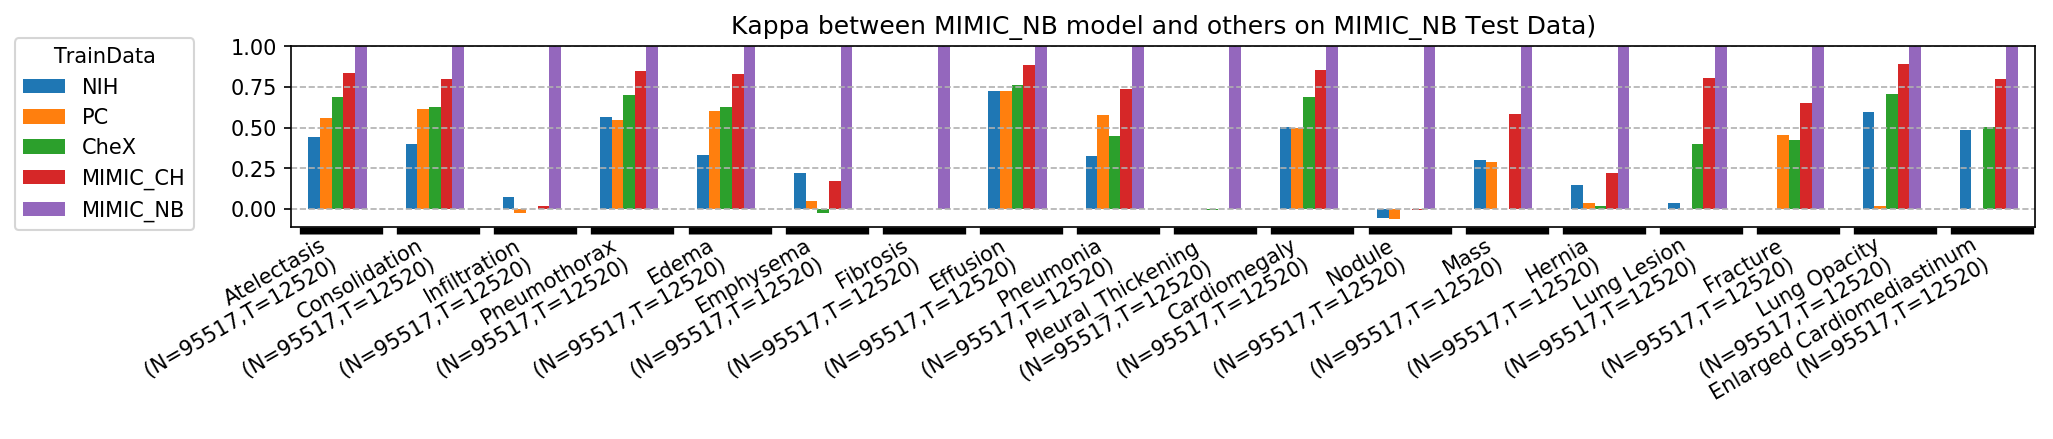

In [67]:
results = agg_results
all_kappas = {}
for model_name in model_names:
    kappas = []
    for i in range(len(datasets.xray.default_pathologies)):
        if len(results[testset_name][0][3][i]) > 0:
            aa = op_thres(results[testset_name][0][3][i], results[testset_name][0][2][i])
            bb = op_thres(results[model_name][0][3][i], results[model_name][0][2][i])

            k = kappa(aa, bb)
            kappas.append(k)
        else:
            kappas.append(-5)
    all_kappas[model_name] = np.asarray(kappas)

plt.figure(0, figsize=(15, 1.6), dpi=150)
index = np.arange(len(np.array(kappas)[tokeep]))  # the label locations
width = 0.12  # the width of the bars

plt.yticks([0,0.25, 0.5,0.75,1])
plt.grid(which='major', axis='y', linestyle='--')

for offset, model_name in enumerate(model_names):
    all_kappas[model_name][all_kappas[model_name]==-5] = 0
    toplot = all_kappas[model_name][tokeep]
    if model_name == "nihpcchexmimic_chmimic_nbgoogle":
        model_name = "Merge"
    plt.bar(index+offset*width, toplot , width, label=model_name);

pathos = []
# counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
# countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
    count = (~np.isnan(agg_results[testset_name][0][3][0])).sum()
    countT = np.nansum((agg_results[testset_name][0][3][0]))
    pathos.append(patho + "\n (N=" + str(int(count))+ ",T=" + str(int(countT)) + ")")

plt.ylim(None,1)
plt.margins(x=0.01)
plt.xticks(index + 2.3*width, 
           pathos,
           rotation='30',horizontalalignment="right", fontsize=10)
ax = plt.gca()
ax.xaxis.set_tick_params(width=40)
plt.tick_params(axis='x', which='major', pad=0)
#if ii == 0:
plt.legend(title="TrainData",bbox_to_anchor=(-0.05, 1.1));
plt.title("Kappa between {} model and others on {} Test Data)".format(testset_name, testset_name));
plt.show()

In [68]:

# results = {}
# for model_name in model_names:
#     results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

# # to avg over seeds
# results = get_avg_auc(results)

# all_kappas = {}
# for model_name in model_names:
#     kappas = []
#     for i in range(len(datasets.xray.default_pathologies)):
#         if len(results[testset_name][0][3][i]) > 0:
#             aa = op_thres(results[testset_name][0][3][i], results[testset_name][0][2][i])
#             bb = op_thres(results[model_name][0][3][i], results[model_name][0][2][i])

#             k = kappa(aa, bb)
#             kappas.append(k)
#         else:
#             kappas.append(-5)
#     all_kappas[model_name] = np.asarray(kappas)

# plt.figure(0, figsize=(15, 1.6), dpi=150)
# index = np.arange(len(np.array(kappas)[tokeep]))  # the label locations
# width = 0.12  # the width of the bars

# plt.yticks([0,0.25, 0.5,0.75,1])
# plt.grid(which='major', axis='y', linestyle='--')

# for offset, model_name in enumerate(model_names):
#     all_kappas[model_name][all_kappas[model_name]==-5] = 0
#     if model_name != "nihpcchexmimic_chmimic_nbgoogle":
#         not_exists_for_model = np.nansum(datasetz[model_name].labels, axis=0) == 0
#         all_kappas[model_name][not_exists_for_model] = 0
#     toplot = all_kappas[model_name][tokeep]
#     if model_name == "nihpcchexmimic_chmimic_nbgoogle":
#         model_name = "Merge"
#     plt.bar(index+offset*width, toplot , width, label=model_name);

# pathos = []
# counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)[tokeep]
# countsT = np.nansum(test_datasets[testset_name].labels, axis=0)[tokeep]
# for i, patho in enumerate(np.array(datasets.xray.default_pathologies)[tokeep]):
#     pathos.append(patho + "\n (N=" + str(int(counts[i]))+ ",T=" + str(int(countsT[i])) + ")")

# plt.ylim(None,1)
# plt.margins(x=0.01)
# plt.xticks(index + 2.3*width, 
#            pathos,
#            rotation='30',horizontalalignment="right", fontsize=10)
# ax = plt.gca()
# ax.xaxis.set_tick_params(width=40)
# plt.tick_params(axis='x', which='major', pad=0)
# if ii == 0:
#     plt.legend(title="TrainData", ncol=2)#,bbox_to_anchor=(-0.05, 1.1));
# plt.title("Kappa between {} model and others on {} Test Data)".format(testset_name, testset_name));
# plt.show()

In [32]:
# i=0
# aa = op_thres(results["NIH"][3][i], results["NIH"][2][i])

In [93]:
# aaa = op_norm(results["NIH"][3][i], results["NIH"][2][i])

In [69]:
# torch.sigmoid_(torch.from_numpy(results[model1][0][2][0])).numpy()

In [94]:
#Bland–Altman

Atelectasis TestData:NIH (N=15403, T=866)


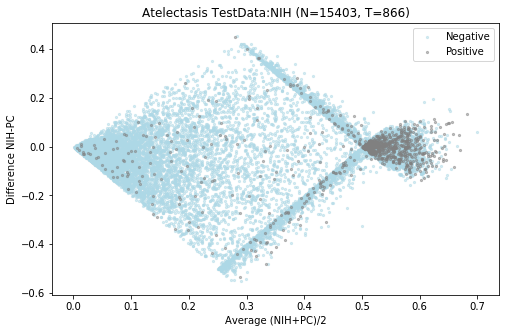

Consolidation TestData:NIH (N=15403, T=203)


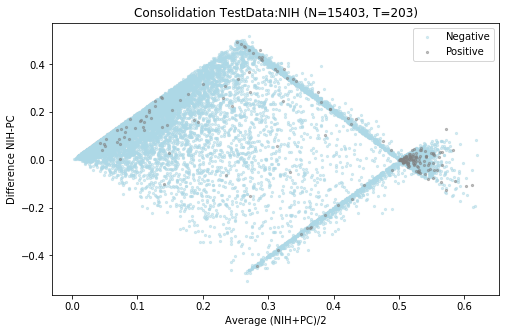

Infiltration TestData:NIH (N=15403, T=1809)


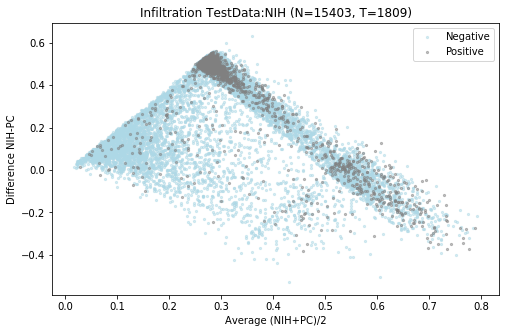

Pneumothorax TestData:NIH (N=15403, T=136)


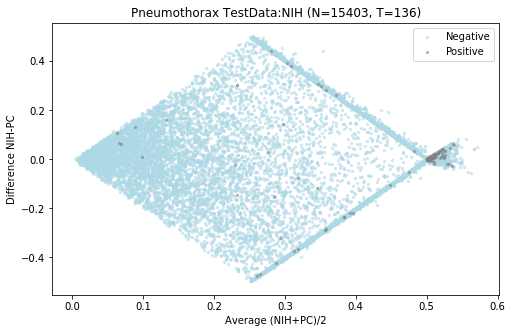

Edema TestData:NIH (N=15403, T=41)


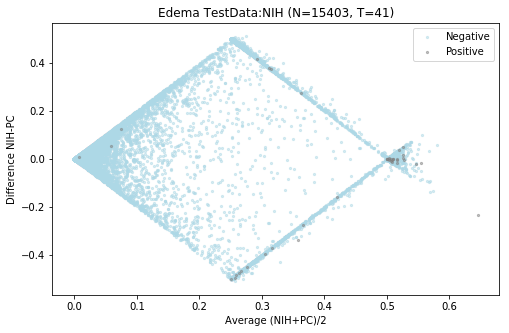

Emphysema TestData:NIH (N=15403, T=126)


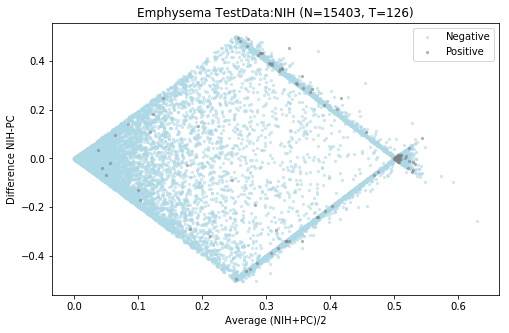

Fibrosis TestData:NIH (N=15403, T=292)


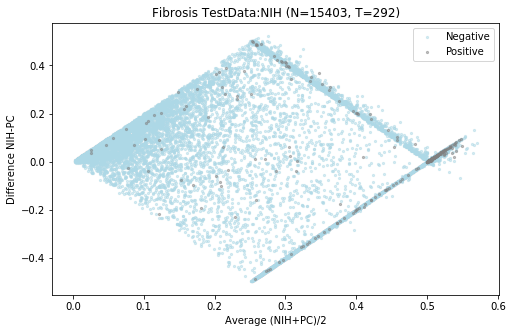

Effusion TestData:NIH (N=15403, T=656)


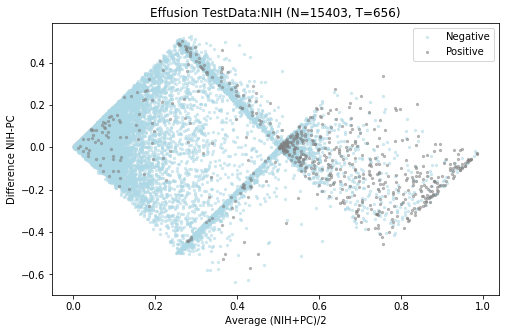

Pneumonia TestData:NIH (N=15403, T=87)


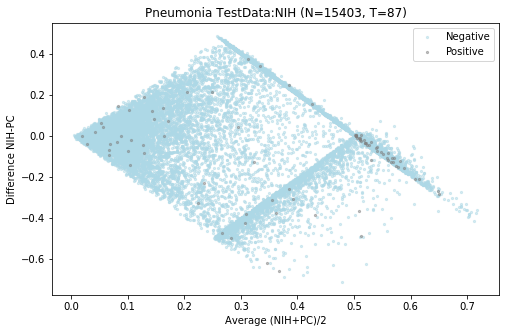

Pleural_Thickening TestData:NIH (N=15403, T=379)


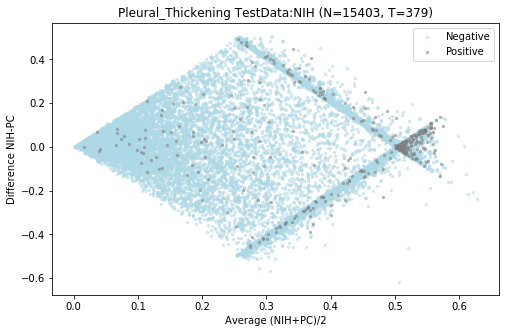

Cardiomegaly TestData:NIH (N=15403, T=399)


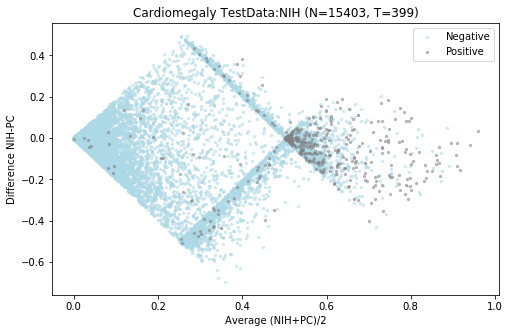

Nodule TestData:NIH (N=15403, T=806)


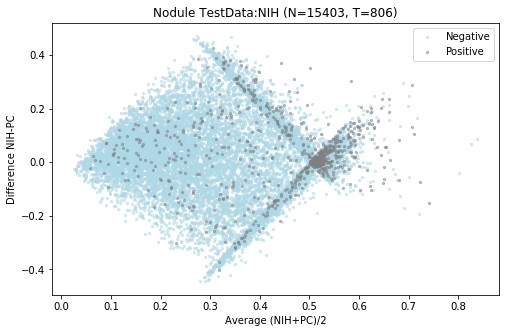

Mass TestData:NIH (N=15403, T=614)


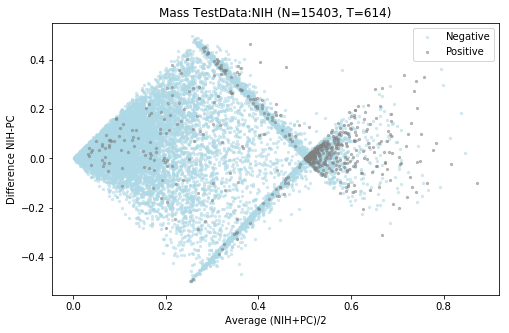

Hernia TestData:NIH (N=15403, T=39)


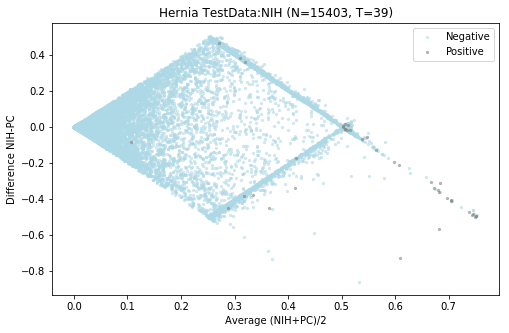

Lung Lesion TestData:NIH (N=0, T=0)
Fracture TestData:NIH (N=0, T=0)
Lung Opacity TestData:NIH (N=0, T=0)
Enlarged Cardiomediastinum TestData:NIH (N=0, T=0)


In [49]:
testset_name = "NIH"

results = {}
for model_name in model_names:
    results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

# to avg over seeds
results = get_avg_auc(results)

model1 = "NIH"
model2 = "PC"

pathos = []
counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)
countsT = np.nansum(test_datasets[testset_name].labels, axis=0)
for i, patho in enumerate(np.array(datasets.xray.default_pathologies)):
    pathos.append(patho + " TestData:{} (N={}, T={})".format(testset_name, int(counts[i]),int(countsT[i])))

for i, patho in enumerate(np.array(datasets.xray.default_pathologies)):
    #aa = results["NIH"][2][i]
    print(pathos[i]);
    if counts[i] == 0:
        continue
    #aa = torch.sigmoid_(torch.from_numpy(results[model1][0][2][i])).numpy()
    aa = op_norm(results[model1][0][3][i], results[model1][0][2][i])
    #bb = torch.sigmoid_(torch.from_numpy(results[model2][0][2][i])).numpy()
    bb = op_norm(results[model2][0][3][i], results[model2][0][2][i])
    y = aa-bb
    x = (aa+bb)/2
    
    f, ax = plt.subplots(1, figsize = (8,5))
    #statsmodels.graphics.mean_diff_plot(aa, bb, ax = ax)
    #plt.title(datasetz["NIH"].pathologies[i])
    #plt.show()
    t = results[testset_name][0][3][i] == 1
    plt.scatter(x=x[~t],y=y[~t], c="lightblue",s=5, alpha=0.5, label="Negative")
    plt.scatter(x=x[t],y=y[t], c="gray",s=5, alpha=0.5, label="Positive")
            

    plt.title(pathos[i])
    plt.xlabel("Average ({}+{})/2".format(model1,model2))
    plt.ylabel("Difference {}-{}".format(model1,model2))
    plt.legend()
    plt.show()

In [ ]:
# for each model run images from each dataset
# take the output layer and plot it

In [43]:
!ls /home/cohenjos/scratch/concept-embedding2/*best*

/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-

In [26]:
# results2 = {}
# model = torch.load("/home/cohenjos/scratch/concept-embedding2/NIH_XrayDataset-densenet121-d121-tw-lr001-best.pt")
# # for dataset_name in dataset_names:
    
# #     results2[dataset_name] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[dataset_name], torch.nn.BCEWithLogitsLoss(), limit=60)


In [93]:
#!nvidia-smi

In [12]:
# torch.cuda.empty_cache()

In [14]:
# d = next(iter(test_loaders["NIH"]))

In [55]:
# outputs = []
# labels = []
# origin = []
# for i, batch in enumerate(test_loaders["NIH"]):
#     print(i)
#     if i > 50: 
#         break;
#     with torch.no_grad():
#         out = model(batch["PA"].cuda())
#         #out = model.features(batch["PA"].cuda())
#         outputs.append(out.detach().cpu().numpy())
#         labels.append(batch["lab"].cpu().numpy())
#         origin.append([0]*cfg.batch_size)

In [56]:
# outputs = np.concatenate(outputs)
# labels = np.concatenate(labels)
# origin = np.concatenate(origin)

In [70]:
import torch.nn.functional as F
def extract(testset_name, thismodel, originid, limit=3000):
    outputs = []
    labels = []
    origin = []
    for i, batch in enumerate(test_loaders[testset_name]):
        print(i)
        if i > limit: 
            break;
        with torch.no_grad():
            #out = model(batch["PA"].cuda())
            out = thismodel.features(batch["PA"].cuda())
            out = F.relu(out, inplace=True)
            out = F.adaptive_avg_pool2d(out, (1, 1))
            #print(out.shape)
            outputs.append(out.detach().cpu().numpy())
            labels.append(batch["lab"].cpu().numpy())
            origin.append([originid]*batch["lab"].cpu().numpy().shape[0])
            
    return merge(outputs, labels, origin)
            
def merge(outputs, labels, origin):
    outputs = np.concatenate(outputs)
    outputs = outputs.reshape(outputs.shape[0], -1)

    labels = np.concatenate(labels)
    origin = np.concatenate(origin)
    
    return outputs, labels, origin
#model = model.cuda();

In [181]:
!ls /home/cohenjos/scratch/concept-embedding2/*best.pt

/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratc

In [182]:
model_names = ['nihpcchexmimic_chmimic_nbgoogle']#['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']

In [183]:
testset_names

['NIH', 'PC', 'CheX', 'NIH_Google', 'MIMIC_CH', 'MIMIC_NB']

In [71]:
# for model_name in model_names:
#     features = {}
#     for i, testset_name in enumerate(testset_names):
#         print(model_name, testset_name)
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_name.lower()))
#         features[testset_name] = extract(testset_name, model, i)
#         pickle.dump(features[testset_name], open("features-m{}-ts{}.pkl".format(model_name, testset_name), "bw"))
        
        

In [21]:
# features = {}
# features["NIH"] = extract("NIH", 0)
# import pickle
# pickle.dump(features["NIH"], open("features-mNIH-tsNIH.pkl", "bw"))
# features["PC"] = extract("PC", 1)
# pickle.dump(features["PC"], open("features-mNIH-tsPC.pkl", "bw"))
# features["CheX"] = extract("CheX", 2)
# pickle.dump(features["CheX"], open("features-mNIH-tsCheX.pkl", "bw"))

In [90]:
import sklearn.metrics.pairwise

def get_feat_dist(testset_name, this_model):
    features = {}
    #for model_name in model_names:
    features[this_model] = pickle.load(open("features-m{}-ts{}.pkl".format(this_model, testset_name), "br"))
        
    subfeats = []
    for i in range(18):
        vecs = features[this_model][0][features[this_model][1][:,i] == 1]
        if vecs.shape[0] == 0:
            vecs = np.zeros([1,vecs.shape[1]])*np.nan
        subfeats.append(vecs.mean(0))
    subfeats = np.array(subfeats)
    
    notnan = ~np.isnan(subfeats.mean(1))
    # real dist 
    d = sklearn.metrics.pairwise_distances(subfeats[notnan], metric="l2")
    
#     # full dist
#     dd = np.zeros([subfeats.shape[0], subfeats.shape[0]])*np.nan
    
#     #integrate smaller into larger dist
#     ii = 0
#     for i, x in enumerate(~np.isnan(subfeats.mean(1))):
#         jj = 0
#         for j, y in enumerate(~np.isnan(subfeats.mean(1))):
#             if x and y:
#                 dd[i,j] = d[ii,jj]
#                 jj += 1
#         if x:
#             ii += 1

    return d


In [73]:
this_model="NIH"

In [106]:
this_model = "MIMIC_CH"
a_dataset = "MIMIC_CH"
b_dataset = "MIMIC_NB"

dm1 = get_feat_dist(testset_name=a_dataset, this_model=this_model)
dm2 = get_feat_dist(testset_name=b_dataset, this_model=this_model)

In [ ]:
# dm = dm1
# dm = dm/np.nanmax(dm)
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if i<j:
#             dm[i,j] = np.nan

# # valid = np.nansum(datasetz[this_model].labels, axis=0) > 0
# # for i in np.arange(0,18):
# #     for j in np.arange(0,18):
# #         if ~valid[i] or ~valid[j]:
# #             dm[i,j] = np.nan

# dm = dm/np.nanmax(dm)
# dm = 1-dm

# plt.figure(0, figsize=(7, 7), dpi=100)
# plt.imshow(dm);
# plt.xticks(range(18),np.array(datasets.xray.default_pathologies),
#            rotation='40',horizontalalignment="right");
# plt.yticks(range(18),np.array(datasets.xray.default_pathologies));

# size = 18
# x_start = -0.5
# x_end = size-0.5
# y_start = -0.5
# y_end = size-0.5

# # Add the text
# jump_x = (x_end - x_start) / (2.0 * size)
# jump_y = (y_end - y_start) / (2.0 * size)
# x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
# y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

# for y_index, y in enumerate(y_positions):
#     for x_index, x in enumerate(x_positions):
#         if ~np.isnan(dm[y_index, x_index]):
#             label = str(int(dm[y_index, x_index]*100))[:4]
#             text_x = x + jump_x
#             text_y = y + jump_y
#             plt.text(text_x, text_y, label, color='black', ha='center', va='center')
# plt.title("Similarity between mean class features on {} dataset using {} model.".format(a_dataset, this_model));


In [ ]:
# dm = dm2
# dm = dm/np.nanmax(dm)
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if i<j:
#             dm[i,j] = np.nan

# valid = np.nansum(datasetz[this_model].labels, axis=0) > 0
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if ~valid[i] or ~valid[j]:
#             dm[i,j] = np.nan

# dm = dm/np.nanmax(dm)
# dm = 1-dm

# plt.figure(0, figsize=(7, 7), dpi=100)
# plt.imshow(dm);
# plt.xticks(range(18),np.array(datasets.xray.default_pathologies),
#            rotation='40',horizontalalignment="right");
# plt.yticks(range(18),np.array(datasets.xray.default_pathologies));

# size = 18
# x_start = -0.5
# x_end = size-0.5
# y_start = -0.5
# y_end = size-0.5

# # Add the text
# jump_x = (x_end - x_start) / (2.0 * size)
# jump_y = (y_end - y_start) / (2.0 * size)
# x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
# y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

# for y_index, y in enumerate(y_positions):
#     for x_index, x in enumerate(x_positions):
#         if ~np.isnan(dm[y_index, x_index]):
#             label = str(int(dm[y_index, x_index]*100))[:4]
#             text_x = x + jump_x
#             text_y = y + jump_y
#             plt.text(text_x, text_y, label, color='black', ha='center', va='center')
# plt.title("Similarity between mean class features on {} dataset using {} model.".format(b_dataset, this_model));


In [ ]:
dm.shape

In [ ]:
dm = np.abs(dm1/np.nanmax(dm1) - dm2/np.nanmax(dm2))
dm = dm/np.nanmax(dm)
for i in np.arange(0,dm.shape[0]):
    for j in np.arange(0,dm.shape[1]):
        if i<j:
            dm[i,j] = np.nan

In [ ]:
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if ~valid[i] or ~valid[j]:
#             dm[i,j] = np.nan

In [ ]:
dm = dm/np.nanmax(dm)

In [ ]:
#dm = 1-dm

In [ ]:
plt.figure(0, figsize=(7, 7), dpi=100)
plt.imshow(dm);
valid = np.nansum(datasetz[this_model].labels, axis=0) > 0

size = valid.sum()

plt.xticks(range(size),np.array(datasets.xray.default_pathologies)[valid],
           rotation='40',horizontalalignment="right");
plt.yticks(range(size),np.array(datasets.xray.default_pathologies)[valid]);




x_start = -0.5
x_end = size-0.5
y_start = -0.5
y_end = size-0.5

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        if ~np.isnan(dm[y_index, x_index]):
            label = str(int(dm[y_index, x_index]*100))[:4]
            text_x = x + jump_x
            text_y = y + jump_y
            plt.text(text_x, text_y, label, color='black', ha='center', va='center')
plt.title("Difference between mean class features between {} and {} datasets using {} model.".format(a_dataset, b_dataset, this_model));


In [28]:
# singlelabel = np.nanargmax(labels, axis=1)
# singlelabel

In [29]:
# #balance
# toselect = []
# for i in range(3):
#     for j in [0,1,2]:
#         pos = np.where((origin == i) & (singlelabel == j))[0][:400]
#         print(pos.shape)
#         toselect.append(pos)
# toselect = np.concatenate(toselect)

In [27]:
#singlelabel[np.nansum(labels[:,:14], axis=1) == 0] = -2

In [147]:
model_names = ["NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB", "nihpcchexmimic_chmimic_nbgoogle"]
model_names

['NIH',
 'PC',
 'CheX',
 'MIMIC_CH',
 'MIMIC_NB',
 'nihpcchexmimic_chmimic_nbgoogle']

In [186]:
testset_name = "MIMIC_CH"

In [187]:
testset_name

'MIMIC_CH'

In [188]:
features = {}
for model_name in model_names:
    features[model_name] = pickle.load(open("features-m{}-ts{}.pkl".format(model_name, testset_name), "br"))

In [189]:
#subset = [k in [1,2,8] for k in singlelabel]

In [190]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(outputs[toselect])
# X_embedded.shape

In [191]:
outputs, labels, origin = features["nihpcchexmimic_chmimic_nbgoogle"]

In [209]:
toselect = np.nansum(labels, axis=1) != 0

In [210]:
import umap
reducer = umap.UMAP()
X_embedded = reducer.fit_transform(outputs[toselect])
X_embedded.shape

/home/cohenjos/.local/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(6295, 2)

In [31]:
%matplotlib inline

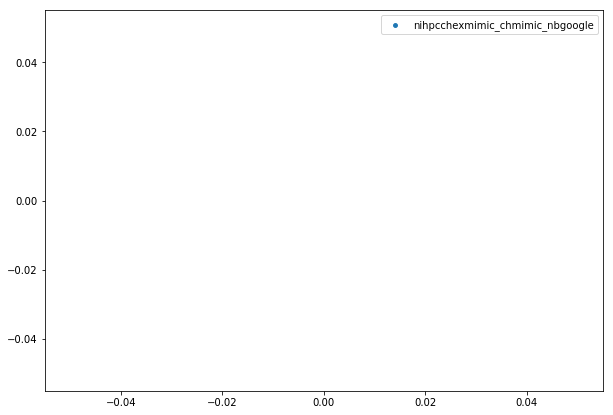

In [194]:
plt.figure(0, figsize=(10, 7))
for ori,name in enumerate(model_names):#zip([0,1,2], ["NIH","PC","CheX"]):
    plt.scatter(X_embedded[origin == ori][:,0], X_embedded[origin == ori][:,1], 
                s=15, cmap=plt.get_cmap("jet"), label=name);
plt.legend();


In [63]:
# labels

In [159]:
# plt.figure(0, figsize=(15, 10))
# for cat in [0,1,2,3]:#range(5):
#     plt.scatter(X_embedded[singlelabel == cat][:,0], X_embedded[singlelabel == cat][:,1], 
#                 s=15, cmap=plt.get_cmap("jet"), label=datasetz["NIH"].pathologies[cat]);
# plt.legend();



In [160]:
cm=plt.get_cmap("jet")
colors = cm(np.linspace(0.5, 1, 14))

In [161]:
highlight = ["Infiltration", 'Consolidation','Pneumonia']

In [195]:
#toselect = np.zeros(labels.shape[0]) == 0

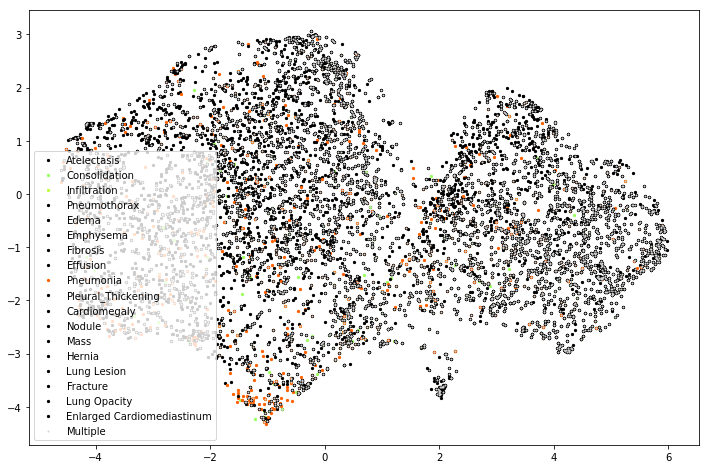

In [211]:
plt.figure(0, figsize=(12, 8))

# none = np.nansum(labels[toselect], axis=1) == 0
# plt.scatter(X_embedded[none][:,0], X_embedded[none][:,1], 
#             c="yellow", label="None", s=10);

for cat in range(18):
    color = colors[cat] if datasetz["NIH"].pathologies[cat] in highlight else "black"
    plt.scatter(X_embedded[labels[toselect][:,cat] == 1][:,0], 
                X_embedded[labels[toselect][:,cat] == 1][:,1], 
                label=datasetz["NIH"].pathologies[cat], s=5, color=color);

multi = np.nansum(labels[toselect], axis=1) > 1
plt.scatter(X_embedded[multi][:,0], X_embedded[multi][:,1], 
            c="lightgray", label="Multiple", s=1);

    
plt.legend();


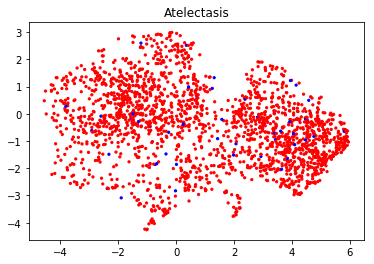

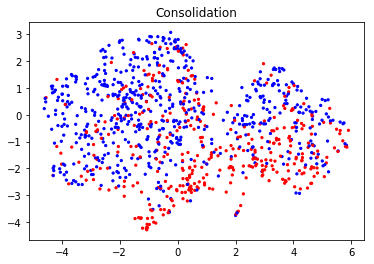

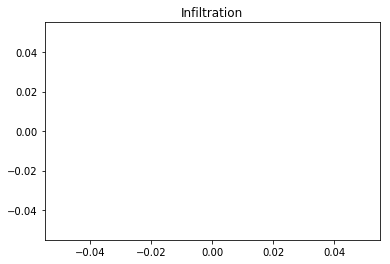

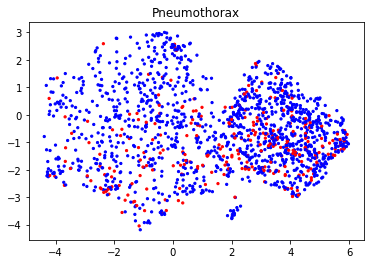

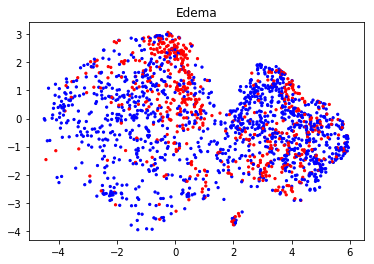

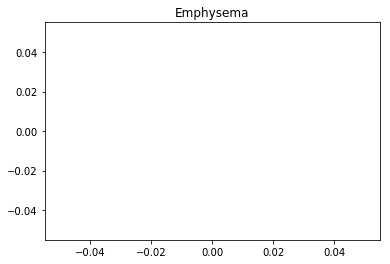

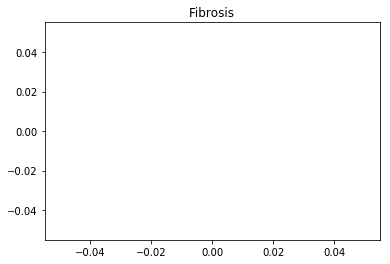

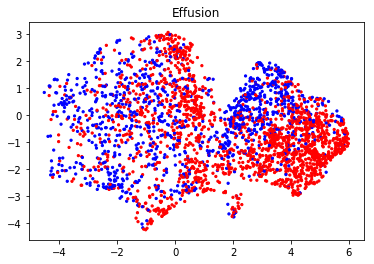

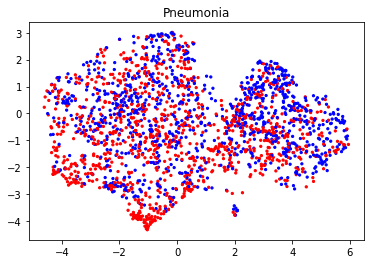

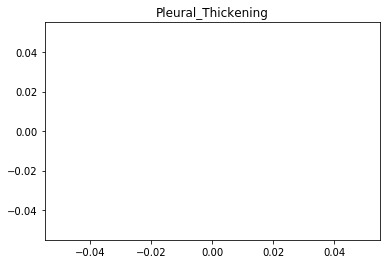

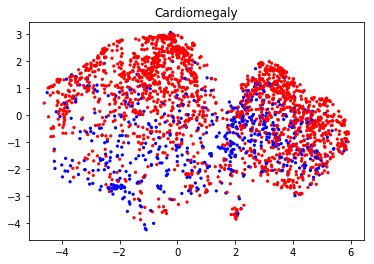

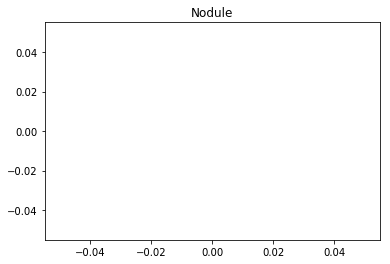

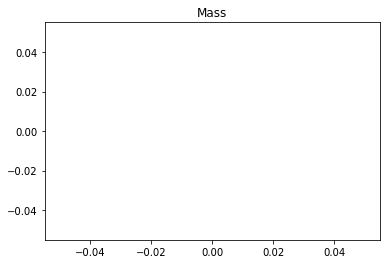

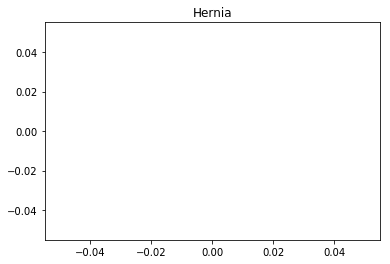

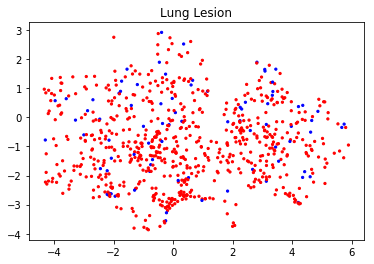

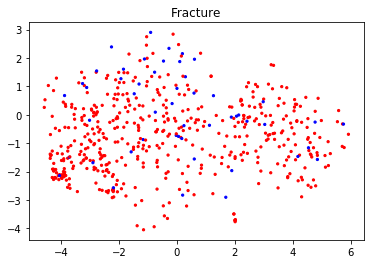

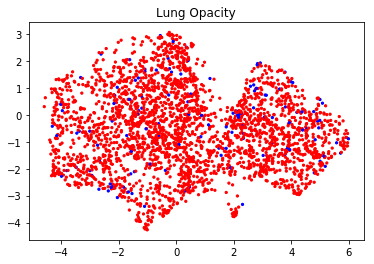

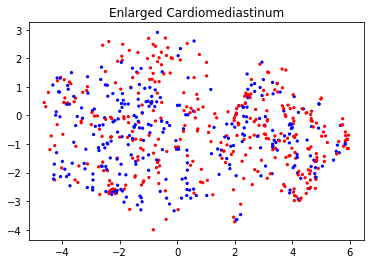

In [213]:
for i, name in enumerate(datasetz["NIH"].pathologies):
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels[toselect][:,i], s=5, cmap=plt.get_cmap("bwr"));
    plt.title(name)
    plt.show()

In [125]:
# for cat in range(30):
#     plt.scatter(X_embedded[cat][0], X_embedded[cat][1], s=1);
#     plt.annotate(cat%10,(X_embedded[cat][0], X_embedded[cat][1]))
# plt.legend();

In [107]:
!ls /home/cohenjos/scratch/concept-embedding2/*best* | grep "nihpcchexmimic_chmimic_nbgoogle"

/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt


In [28]:
model_dataset = "nihpcchexmimic_chmimic_nbgoogle"

In [109]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()


In [117]:
def get_weights(seed=0):
    model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_dataset, seed))
    weight = model.classifier.weight.detach().cpu().numpy()
    return weight
dmatrix = np.mean([sklearn.metrics.pairwise_distances(get_weights(i), metric="l2") for i in range(3)], axis=0)
    

In [33]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2, perplexity=2).fit_transform(weight)
# X_embedded.shape

In [34]:
# import umap
# reducer = umap.UMAP()
# X_embedded = reducer.fit_transform(weight)
# X_embedded.shape

In [111]:
import sklearn, sklearn.decomposition
X_embedded = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)
X_embedded.shape

(18, 2)

In [112]:
#notnull = np.nansum(datasetz[model_dataset].labels,axis=0) > 0

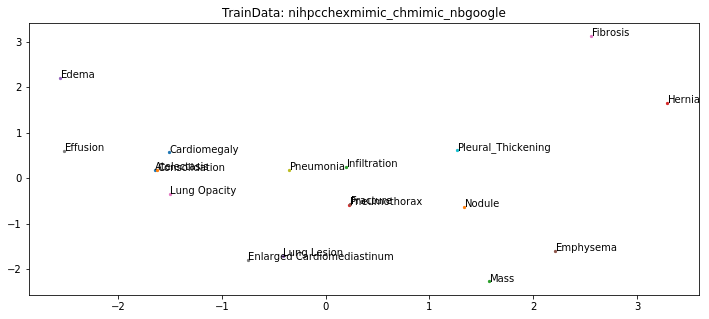

In [113]:
plt.figure(0, figsize=(12, 5))

for cat in range(18):
#    if model_dataset=="Merge" or notnull[cat]:
    plt.scatter(X_embedded[cat][0], 
                X_embedded[cat][1], 
                label=datasetz["NIH"].pathologies[cat], s=5);
    plt.annotate(datasetz["NIH"].pathologies[cat],(X_embedded[cat][0], X_embedded[cat][1]))

plt.title("TrainData: " + model_dataset);

In [102]:
# plt.figure(0, figsize=(12, 5))

# for cat in range(18):
# #    if model_dataset=="Merge" or notnull[cat]:
#     plt.scatter(X_embedded[cat][0], 
#                 X_embedded[cat][1], 
#                 label=datasetz["NIH"].pathologies[cat], s=5);
#     plt.annotate(datasetz["NIH"].pathologies[cat],(X_embedded[cat][0], X_embedded[cat][1]))

# plt.title("TrainData: " + model_dataset);

In [130]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB', "nihpcchexmimic_chmimic_nbgoogle"]

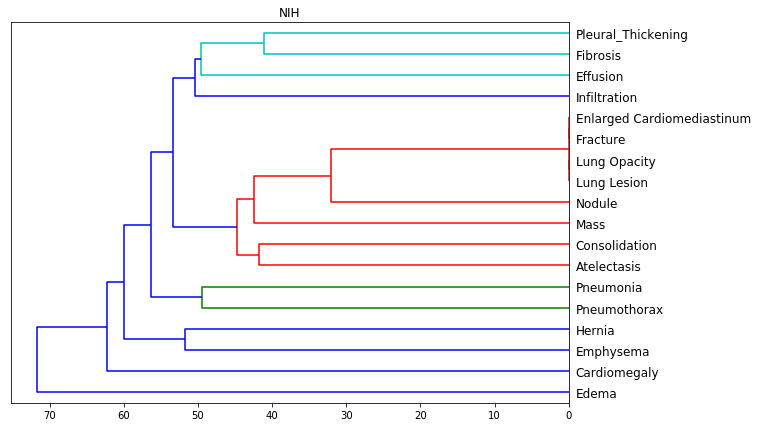

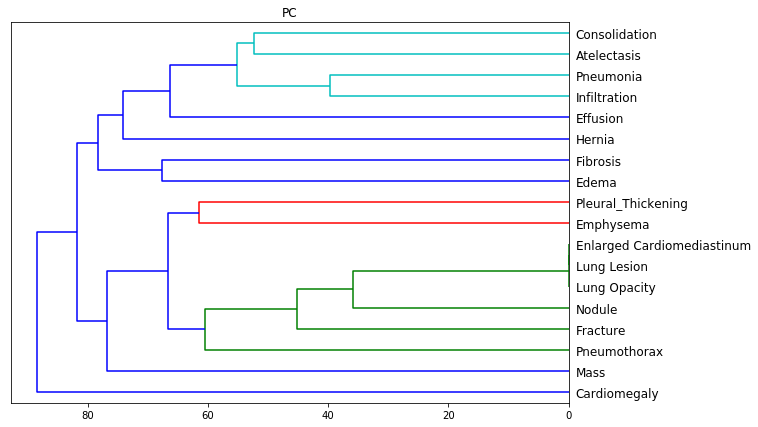

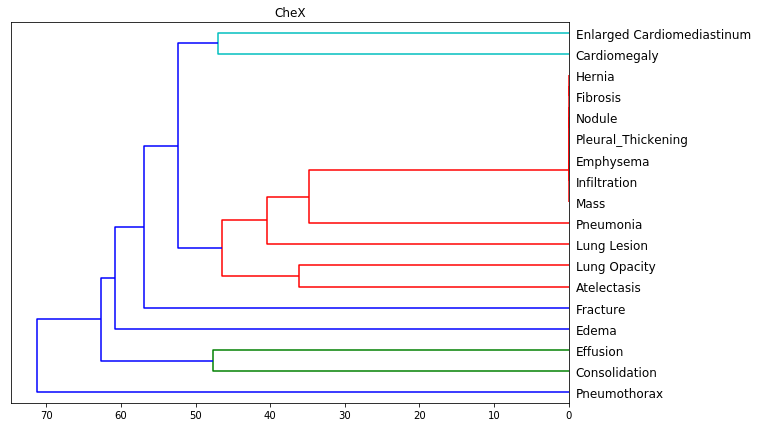

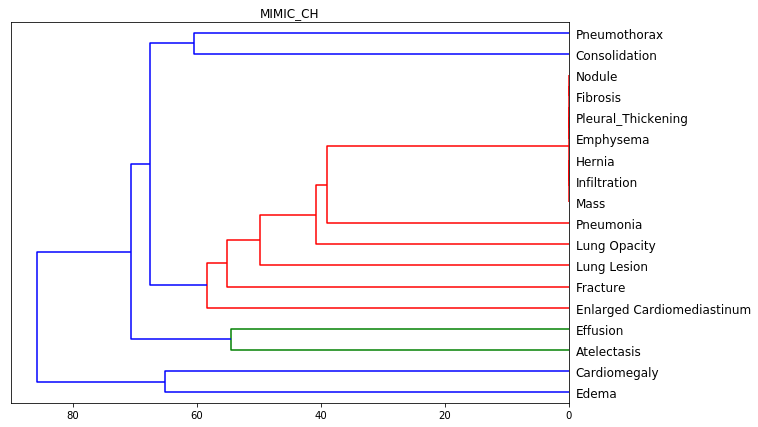

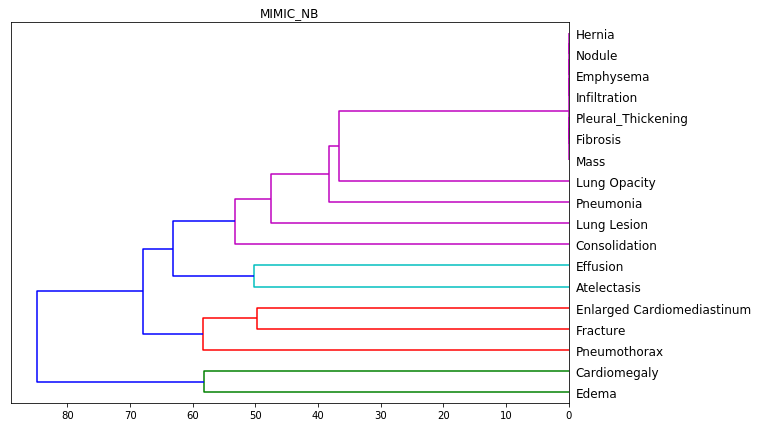

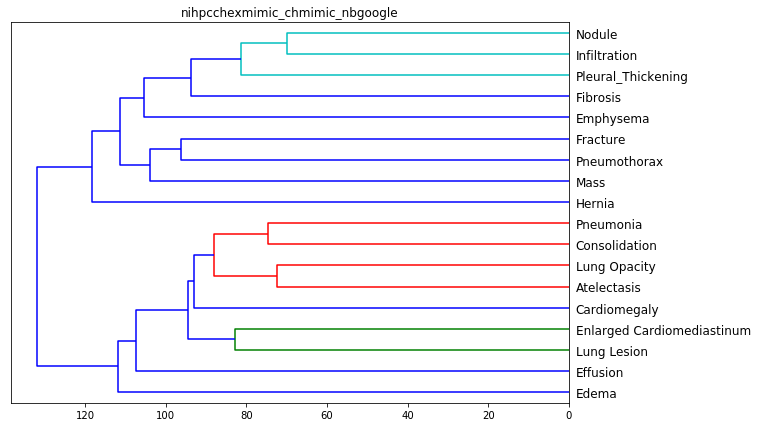

In [136]:
def get_weights(model_name, seed):
    model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_name.lower(), seed))
    weights = model.classifier.weight.detach().cpu().numpy()
    return weights


for model_name in model_names:

    dmatrix = np.mean([sklearn.metrics.pairwise_distances(get_weights(model_name, i), metric="l1") for i in range(3)], axis=0)


    from scipy.cluster.hierarchy import dendrogram, linkage
    from matplotlib import pyplot as plt
    import scipy

    linked = linkage(scipy.spatial.distance.squareform(dmatrix), 'complete', metric="l1")

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='left',
                labels=datasetz["NIH"].pathologies,
                distance_sort='descending',
                show_leaf_counts=True)#, leaf_rotation=90)
    plt.title(model_name)
    plt.show()

In [104]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(weight, 'complete')

# plt.figure(figsize=(10, 7))
# dendrogram(linked,
#             orientation='left',
#             labels=datasetz["NIH"].pathologies,
#             distance_sort='descending',
#             show_leaf_counts=True)#, leaf_rotation=90)
# plt.show()

In [96]:
weight.shape

(18, 1024)

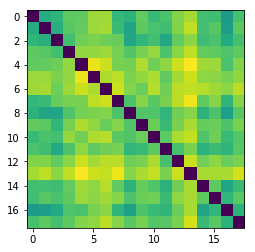

In [86]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()
d = sklearn.metrics.pairwise_distances(weight, metric="l2")
plt.imshow(d)

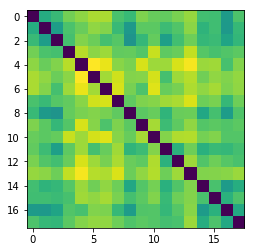

In [78]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()
d = sklearn.metrics.pairwise_distances(weight, metric="l2")
plt.imshow(d)